# Client Reorder Prediction Model
## Objective: Predict when a client will order which product again

This notebook explores expedition data to build a predictive model for client reordering patterns.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


## 2. Load Data

In [2]:
# CELL: Load and clean dataset - Exclude 2022 data
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_excel('soya_data_cleaned_2023_onwards.xlsx')

print(f"Dataset loaded: {df.shape[0]:,} rows and {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Data Cleaning
print("\n" + "="*80)
print("DATA CLEANING")
print("="*80)

initial_rows = len(df)

# Convert date column to datetime to filter by year
df['sales_order_creation_date'] = pd.to_datetime(df['sales_order_creation_date'], errors='coerce')
df['year'] = df['sales_order_creation_date'].dt.year

# Convert quantity column to numeric for filtering
df['total_amount_delivered_tm'] = pd.to_numeric(df['total_amount_delivered_tm'], errors='coerce')

# Count records to be excluded
print("\nRecords to be excluded:")
print("-"*80)
year_2022_count = (df['year'] == 2022).sum()
empty_clients = (df['client_name'].isna() | (df['client_name'] == '')).sum()
zero_quantity = (df['total_amount_delivered_tm'] == 0).sum()
na_quantity = df['total_amount_delivered_tm'].isna().sum()

print(f"Records from 2022: {year_2022_count:,}")
print(f"Records with empty clients: {empty_clients:,}")
print(f"Records with 0 TM quantity: {zero_quantity:,}")
print(f"Records with NA quantity: {na_quantity:,}")

# Apply filters
print("\n" + "-"*80)
print("Applying filters...")
print("-"*80)

# Filter out 2022 data
df = df[df['year'] != 2022]
print(f"After excluding 2022: {len(df):,} rows remaining")

# Filter out empty clients
df = df[df['client_name'].notna() & (df['client_name'] != '')]
print(f"After excluding empty clients: {len(df):,} rows remaining")

# Filter out zero/NA quantity orders
df = df[df['total_amount_delivered_tm'].notna()]
print(f"After excluding NA quantity: {len(df):,} rows remaining")

df = df[df['total_amount_delivered_tm'] > 0]
print(f"After excluding zero quantity: {len(df):,} rows remaining")

final_rows = len(df)
excluded = initial_rows - final_rows

print("\n" + "="*80)
print("CLEANING SUMMARY")
print("="*80)
print(f"Initial rows: {initial_rows:,}")
print(f"Final rows: {final_rows:,}")
print(f"Rows excluded: {excluded:,} ({excluded/initial_rows*100:.2f}%)")

# Show year distribution after cleaning
print("\n" + "-"*80)
print("Year distribution after cleaning:")
print("-"*80)
year_counts = df['year'].value_counts().sort_index()
for year, count in year_counts.items():
    pct = count / final_rows * 100
    print(f"  {year}: {count:,} rows ({pct:.1f}%)")

print("\n✓ Data cleaning complete")
print(f"✓ Dataset now contains data from {df['year'].min():.0f} to {df['year'].max():.0f}")

# Display column names for reference
print("\n" + "="*80)
print("AVAILABLE COLUMNS")
print("="*80)
print(df.columns.tolist())

Dataset loaded: 15,297 rows and 25 columns
Memory usage: 8.23 MB

DATA CLEANING

Records to be excluded:
--------------------------------------------------------------------------------
Records from 2022: 0
Records with empty clients: 0
Records with 0 TM quantity: 0
Records with NA quantity: 0

--------------------------------------------------------------------------------
Applying filters...
--------------------------------------------------------------------------------
After excluding 2022: 15,297 rows remaining
After excluding empty clients: 15,297 rows remaining
After excluding NA quantity: 15,297 rows remaining
After excluding zero quantity: 15,297 rows remaining

CLEANING SUMMARY
Initial rows: 15,297
Final rows: 15,297
Rows excluded: 0 (0.00%)

--------------------------------------------------------------------------------
Year distribution after cleaning:
--------------------------------------------------------------------------------
  2023: 5,758 rows (37.6%)
  2024: 7,091 

In [3]:
# CELL: Verify 2022 exclusion and data quality
print("="*80)
print("DATA QUALITY VERIFICATION")
print("="*80)

# Verify no 2022 data remains
print("\n1. YEAR VERIFICATION:")
print("-"*80)
if 2022 in df['year'].values:
    print("⚠️  WARNING: 2022 data still present!")
else:
    print("✓ Confirmed: No 2022 data in dataset")

print(f"\nYear range: {df['year'].min():.0f} - {df['year'].max():.0f}")
print(f"Years present: {sorted(df['year'].unique())}")

# Verify no empty clients
print("\n2. CLIENT VERIFICATION:")
print("-"*80)
empty_check = (df['client_name'].isna() | (df['client_name'] == '')).sum()
if empty_check > 0:
    print(f"⚠️  WARNING: {empty_check} empty client names found!")
else:
    print("✓ Confirmed: All records have valid client names")

print(f"Unique clients: {df['client_name'].nunique():,}")

# Verify no zero/NA quantities
print("\n3. QUANTITY VERIFICATION:")
print("-"*80)
zero_check = (df['total_amount_delivered_tm'] == 0).sum()
na_check = df['total_amount_delivered_tm'].isna().sum()

if zero_check > 0:
    print(f"⚠️  WARNING: {zero_check} records with zero quantity!")
if na_check > 0:
    print(f"⚠️  WARNING: {na_check} records with NA quantity!")
    
if zero_check == 0 and na_check == 0:
    print("✓ Confirmed: All records have valid positive quantities")

print(f"\nQuantity statistics:")
print(f"  - Min: {df['total_amount_delivered_tm'].min():.2f} TM")
print(f"  - Max: {df['total_amount_delivered_tm'].max():.2f} TM")
print(f"  - Mean: {df['total_amount_delivered_tm'].mean():.2f} TM")
print(f"  - Median: {df['total_amount_delivered_tm'].median():.2f} TM")

# Date range verification
print("\n4. DATE RANGE VERIFICATION:")
print("-"*80)
print(f"Earliest order: {df['sales_order_creation_date'].min().date()}")
print(f"Latest order: {df['sales_order_creation_date'].max().date()}")
print(f"Total days span: {(df['sales_order_creation_date'].max() - df['sales_order_creation_date'].min()).days:,} days")

print("\n" + "="*80)
print("✓ Data quality verification complete")
print("="*80)

DATA QUALITY VERIFICATION

1. YEAR VERIFICATION:
--------------------------------------------------------------------------------
✓ Confirmed: No 2022 data in dataset

Year range: 2023 - 2025
Years present: [np.int32(2023), np.int32(2024), np.int32(2025)]

2. CLIENT VERIFICATION:
--------------------------------------------------------------------------------
✓ Confirmed: All records have valid client names
Unique clients: 247

3. QUANTITY VERIFICATION:
--------------------------------------------------------------------------------
✓ Confirmed: All records have valid positive quantities

Quantity statistics:
  - Min: 0.34 TM
  - Max: 46.34 TM
  - Mean: 18.42 TM
  - Median: 17.94 TM

4. DATE RANGE VERIFICATION:
--------------------------------------------------------------------------------
Earliest order: 2023-01-03
Latest order: 2025-09-16
Total days span: 987 days

✓ Data quality verification complete


## 3. Initial Data Exploration

In [4]:
# Display first few rows
print("First 10 rows of the dataset:")
df.head(10)

First 10 rows of the dataset:


,expedition_number,client_order_number,product_name,client_name,postal_code_client,city_client,country_client,sales_order_creation_date,promised_expedition_date,actual_expedition_date,date_and_time_expedition,contract_number,\ntotal_ordered_converted,total_amount_ordered_tm,total_amount_delivered_tm,city_of_delivery,inventory_tag,inventory_location,total_ordered_converted,purchasing_order_number,trucking_company_name,bill_number,cost_of_purchased_order,quantity_of_purchase_order,year
0,231352.0,SO-11118,Huile de Soya,MEUNERIE MARIO BERARD INC,J0E 1E0,ANGE-GARDIEN,canada,2023-01-03,2023-01-03,2023-01-04 15:37:01,NaT,NaN,NaN,3.00,2.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
1,231353.0,SO-11119,Trituro Laitier - Régulier,FERME QUIKO INC,J0J 1Y0,SAINT-IGNACE-DE-STANBRIDGE,canada,2023-01-03,2023-01-05,2023-01-05 09:16:47,NaT,NaN,NaN,5.00,5.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
2,231356.0,SO-11120,Trituro Laitier - Régulier,LES MOULEES BELLIFRANCE,J2R 1E9,SAINT-HYACINTHE,canada,2023-01-03,2023-01-06,2023-01-05 14:01:47,NaT,NaN,NaN,3.10,3.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
3,231354.0,SO-11120,Trituro Laitier - Régulier,LES MOULEES BELLIFRANCE,J2R 1E9,SAINT-HYACINTHE,canada,2023-01-03,2023-01-06,2023-01-06 12:03:53,NaT,NaN,NaN,4.62,4.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
4,231355.0,SO-11121,Trituro Laitier - Régulier,SOLLIO AGRICULTURE S.E.C.,G6E 0L9,Sainte-Marie,canada,2023-01-03,2023-01-05,2023-01-05 07:39:39,NaT,NaN,NaN,3.15,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
5,231357.0,SO-11122,Huile de Soya,MACEWEN AGRICENTRE INC,K0C 1T0,MAXVILLE,canada,2023-01-03,2023-01-04,2023-01-05 16:21:49,NaT,NaN,NaN,4.00,1.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
6,231358.0,SO-11123,Huile de Soya,NOVA GRAIN INC USD,05855 - 2205,NEWPORT,usa,2023-01-03,2023-01-06,2023-01-06 12:55:11,NaT,NaN,NaN,16.23,16.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
7,231359.0,SO-11124,Huile de Soya,FERME MONIQUE & GAETAN THIBERT/1048564 ONTARIO...,K0A 1M0,CASSELMAN,canada,2023-01-03,2023-01-11,2023-01-12 14:01:09,NaT,NaN,NaN,6.00,3.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
8,231360.0,SO-11125,Excel Profibre,PROREC INC,J2S 9B2,SAINT-HYACINTHE,canada,2023-01-04,NaT,2023-01-05 11:51:31,NaT,CT-10311(200|2023-01-31),NaN,15.24,15.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
9,231361.0,SO-11126,Écales de Soya - Brutes,PROREC INC,J2S 9B2,SAINT-HYACINTHE,canada,2023-01-04,2023-01-05,2023-01-05 11:13:23,NaT,CT-10312(300|2023-12-31),NaN,15.00,6.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023


In [5]:
# Display basic information about the dataset
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15297 entries, 0 to 15296
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   expedition_number           15250 non-null  float64       
 1   client_order_number         15297 non-null  object        
 2   product_name                15297 non-null  object        
 3   client_name                 15297 non-null  object        
 4   postal_code_client          15194 non-null  object        
 5   city_client                 15204 non-null  object        
 6   country_client              15103 non-null  object        
 7   sales_order_creation_date   15297 non-null  datetime64[ns]
 8   promised_expedition_date    10139 non-null  datetime64[ns]
 9   actual_expedition_date      15297 non-null  datetime64[ns]
 10  date_and_time_expedition    6347 non-null   datetime64[ns]
 11  contract_number             5248 non-nul

In [6]:
# Column names
print(f"Total columns: {len(df.columns)}\n")
print("Column names:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

Total columns: 25

Column names:
 1. expedition_number
 2. client_order_number
 3. product_name
 4. client_name
 5. postal_code_client
 6. city_client
 7. country_client
 8. sales_order_creation_date
 9. promised_expedition_date
10. actual_expedition_date
11. date_and_time_expedition
12. contract_number
13. 
total_ordered_converted
14. total_amount_ordered_tm
15. total_amount_delivered_tm
16. city_of_delivery
17. inventory_tag
18. inventory_location
19. total_ordered_converted
20. purchasing_order_number
21. trucking_company_name
22. bill_number
23. cost_of_purchased_order
24. quantity_of_purchase_order
25. year


In [7]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

if duplicates > 0:
    print("\nExample duplicate rows:")
    display(df[df.duplicated(keep=False)].head(10))

Number of duplicate rows: 0 (0.00%)


## 4. Missing Data Analysis

In [8]:
# Calculate missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print(f"Columns with missing values: {len(missing_data)} out of {len(df.columns)}\n")
display(missing_data)

Columns with missing values: 18 out of 25



,Column,Missing_Count,Missing_Percentage
cost_of_purchased_order,cost_of_purchased_order,15297,100.00
city_of_delivery,city_of_delivery,15297,100.00
quantity_of_purchase_order,quantity_of_purchase_order,15297,100.00
total_ordered_converted,total_ordered_converted,15297,100.00
bill_number,bill_number,15297,100.00
trucking_company_name,trucking_company_name,15297,100.00
purchasing_order_number,purchasing_order_number,15297,100.00
inventory_tag,inventory_tag,15297,100.00
inventory_location,inventory_location,15297,100.00
contract_number,contract_number,10049,65.69


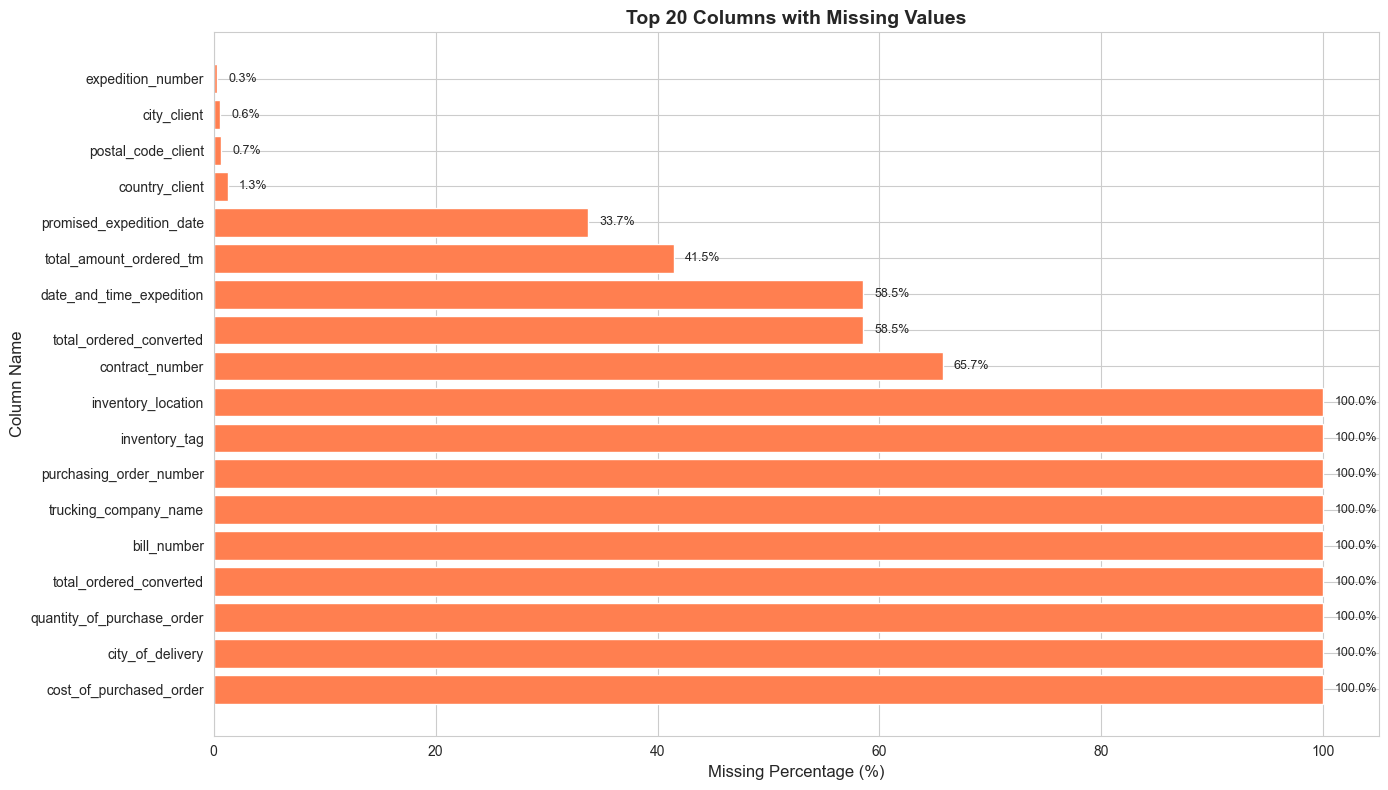

In [9]:
# Visualize missing data
if len(missing_data) > 0:
    plt.figure(figsize=(14, 8))
    top_missing = missing_data.head(20)
    
    bars = plt.barh(top_missing['Column'], top_missing['Missing_Percentage'], color='coral')
    plt.xlabel('Missing Percentage (%)', fontsize=12)
    plt.ylabel('Column Name', fontsize=12)
    plt.title('Top 20 Columns with Missing Values', fontsize=14, fontweight='bold')
    
    # Add percentage labels on bars
    for i, (bar, pct) in enumerate(zip(bars, top_missing['Missing_Percentage'])):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                f'{pct:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## 5. Key Variables Analysis

In [10]:
# Analyze key columns for our prediction task
key_columns = ['client_name', 'product_name', 'sales_order_creation_date', 
               'actual_expedition_date', 'promised_expedition_date', 
               'total_amount_delivered_tm']

print("Analysis of key columns for reorder prediction:\n")
for col in key_columns:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"  - Non-null count: {df[col].notna().sum():,} ({df[col].notna().sum()/len(df)*100:.2f}%)")
        print(f"  - Unique values: {df[col].nunique():,}")
        if df[col].dtype == 'object' and df[col].nunique() < 50:
            print(f"  - Sample values: {df[col].dropna().unique()[:5].tolist()}")
    else:
        print(f"\n{col}: NOT FOUND IN DATASET")

Analysis of key columns for reorder prediction:


client_name:
  - Non-null count: 15,297 (100.00%)
  - Unique values: 247

product_name:
  - Non-null count: 15,297 (100.00%)
  - Unique values: 49
  - Sample values: ['Huile de Soya', 'Trituro Laitier - Régulier', 'Excel Profibre', 'Écales de Soya - Brutes', 'Trituro Laitier Biologique']

sales_order_creation_date:
  - Non-null count: 15,297 (100.00%)
  - Unique values: 685

actual_expedition_date:
  - Non-null count: 15,297 (100.00%)
  - Unique values: 2,230

promised_expedition_date:
  - Non-null count: 10,139 (66.28%)
  - Unique values: 690

total_amount_delivered_tm:
  - Non-null count: 15,297 (100.00%)
  - Unique values: 3,789


## 5.1 Order Quantity Categorization

Creating meaningful categories based on `total_amount_delivered_tm` to understand order patterns.

ORDER QUANTITY CATEGORIZATION

1. EXPLORATORY ANALYSIS OF total_amount_delivered_tm
--------------------------------------------------------------------------------

Descriptive Statistics:
count    15297.000000
mean        18.415928
std         13.419697
min          0.340000
25%          5.060000
50%         17.940000
75%         31.890000
max         46.341000
Name: total_amount_delivered_tm, dtype: float64

Detailed Percentiles:
  10th percentile: 3.05 TM
  25th percentile: 5.06 TM
  50th percentile: 17.94 TM
  75th percentile: 31.89 TM
  90th percentile: 37.45 TM
  95th percentile: 38.03 TM
  99th percentile: 39.81 TM

Top 20 Most Common Order Quantities (rounded):
total_amount_delivered_tm
4.0     1334
38.0    1095
3.0     1052
37.0     864
5.0      813
36.0     790
6.0      723
21.0     690
2.0      656
8.0      541
30.0     497
7.0      486
20.0     470
10.0     462
25.0     327
22.0     285
1.0      273
9.0      272
23.0     260
35.0     256
Name: count, dtype: int64

Orders i

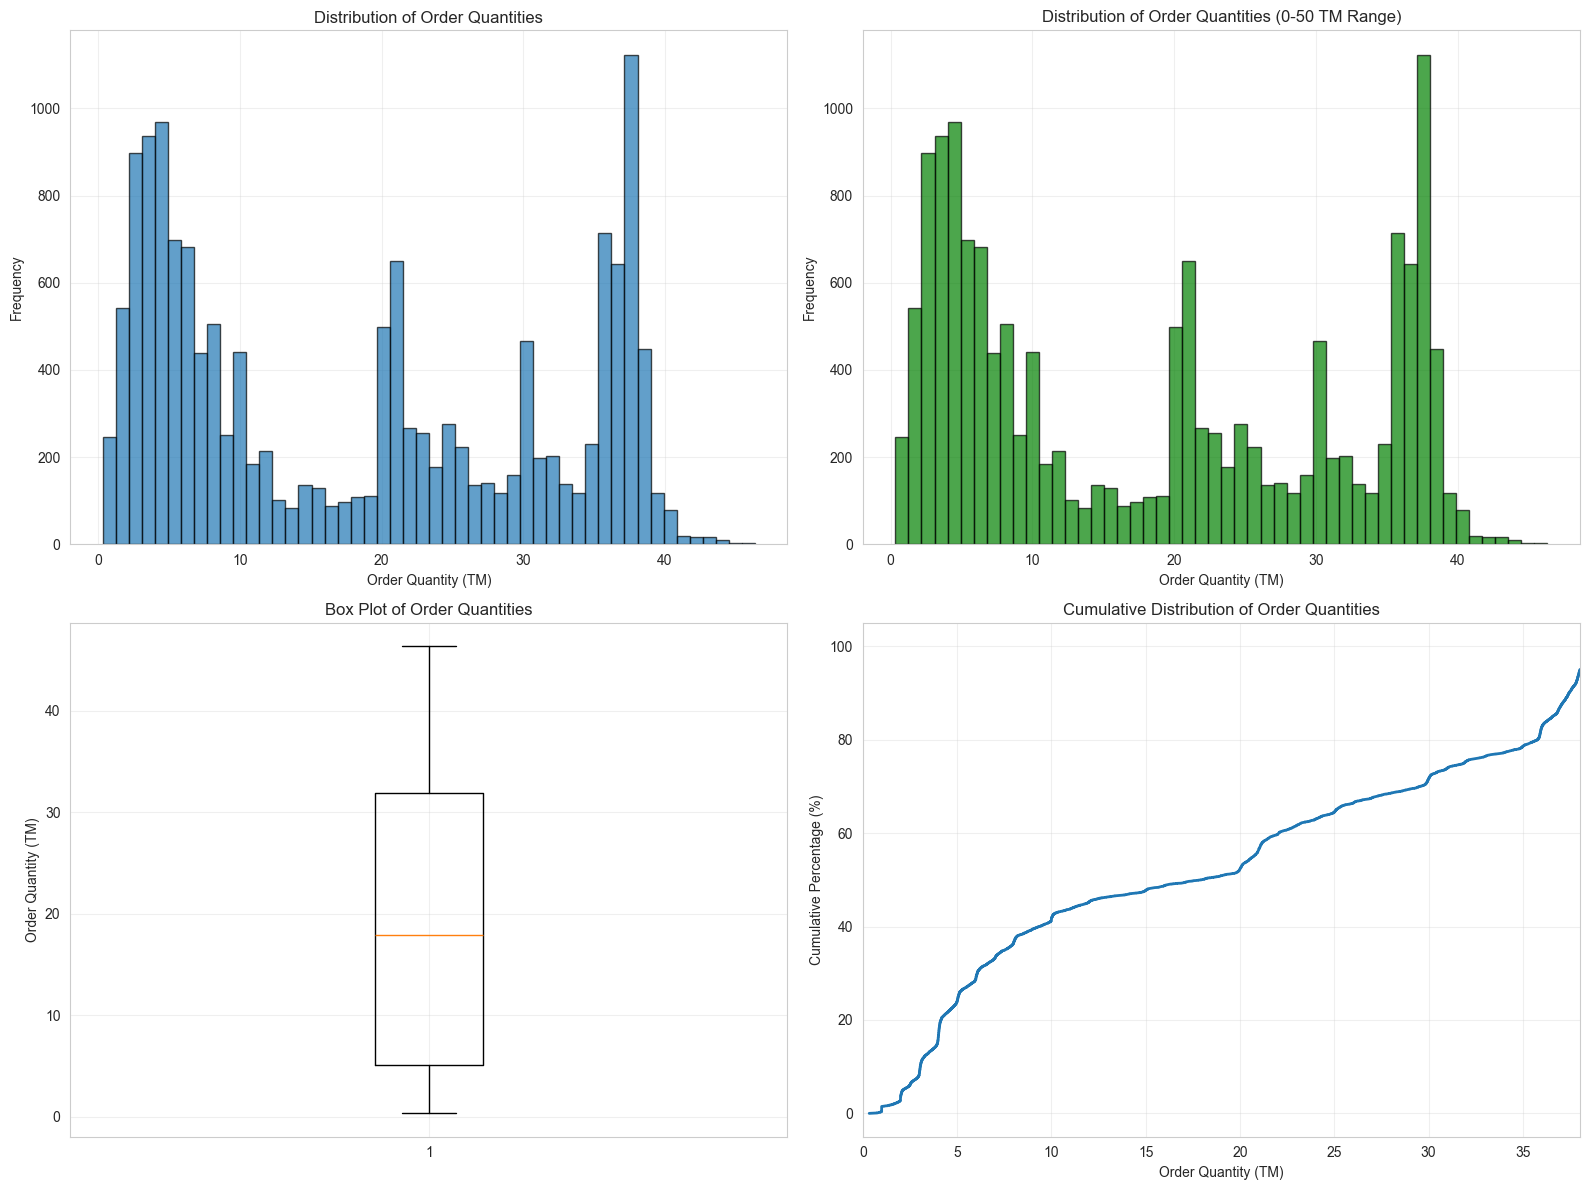


3. CREATING ORDER QUANTITY CATEGORIES
--------------------------------------------------------------------------------

Category Definition:
  - Small: 0-5 TM
  - Medium: 5-10 TM (Business focus range)
  - Large: 10-20 TM
  - Extra Large: 20+ TM

4. DISTRIBUTION OF ORDER SIZE CATEGORIES
--------------------------------------------------------------------------------

Category Counts:
order_size_category
Small (0-5 TM)          3673
Medium (5-10 TM)        2714
Large (10-20 TM)        1616
Extra Large (20+ TM)    7294
Name: count, dtype: int64

Category Percentages:
  Small (0-5 TM): 24.01%
  Medium (5-10 TM): 17.74%
  Large (10-20 TM): 10.56%
  Extra Large (20+ TM): 47.68%

Statistics by Category:
                      count       mean  median        min     max
order_size_category                                              
Small (0-5 TM)         3673   3.230767   3.240   0.340000   5.000
Medium (5-10 TM)       2714   7.063277   6.920   5.010000  10.000
Large (10-20 TM)       1616 

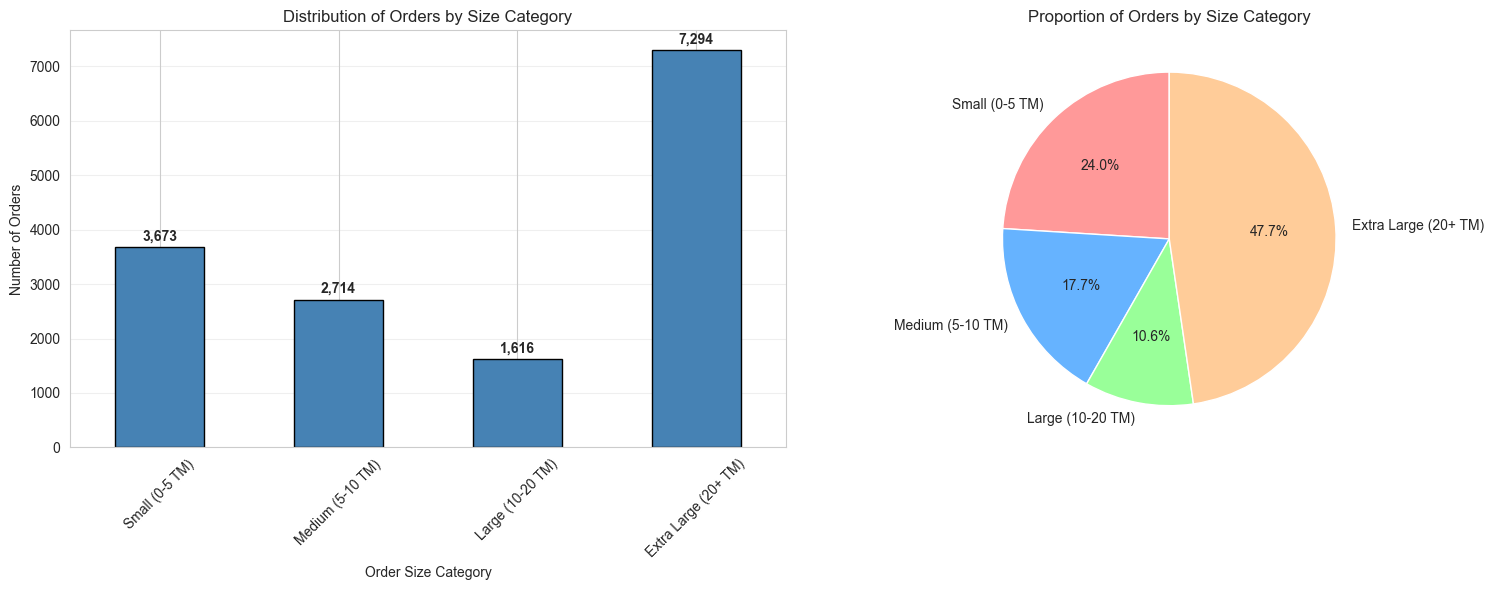


New column 'order_size_category' has been added to the dataframe
Total orders categorized: 15,297


In [11]:
# CELL: Order Quantity Categorization Analysis
print("="*80)
print("ORDER QUANTITY CATEGORIZATION")
print("="*80)

# 1. EXPLORATORY ANALYSIS OF QUANTITY DISTRIBUTION
print("\n1. EXPLORATORY ANALYSIS OF total_amount_delivered_tm")
print("-" * 80)

# Basic statistics
print("\nDescriptive Statistics:")
print(df['total_amount_delivered_tm'].describe())

# Additional percentiles for better understanding
percentiles = [0.1, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99]
print("\nDetailed Percentiles:")
for p in percentiles:
    value = df['total_amount_delivered_tm'].quantile(p)
    print(f"  {int(p*100)}th percentile: {value:.2f} TM")

# Value counts for most common quantities (rounded to nearest integer)
print("\nTop 20 Most Common Order Quantities (rounded):")
rounded_quantities = df['total_amount_delivered_tm'].round(0)
print(rounded_quantities.value_counts().head(20))

# Check distribution around the 5-10 range specifically
print("\nOrders in the 5-10 TM range:")
orders_5_to_10 = df[(df['total_amount_delivered_tm'] >= 5) & 
                     (df['total_amount_delivered_tm'] <= 10)]
print(f"  Count: {len(orders_5_to_10):,} orders ({len(orders_5_to_10)/len(df)*100:.2f}%)")

# 2. CREATE VISUALIZATION
print("\n2. QUANTITY DISTRIBUTION VISUALIZATION")
print("-" * 80)

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram of all quantities
axes[0, 0].hist(df['total_amount_delivered_tm'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Order Quantity (TM)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Order Quantities')
axes[0, 0].grid(True, alpha=0.3)

# Histogram focusing on 0-50 TM range (where most data likely is)
subset_50 = df[df['total_amount_delivered_tm'] <= 50]
axes[0, 1].hist(subset_50['total_amount_delivered_tm'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Order Quantity (TM)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Order Quantities (0-50 TM Range)')
axes[0, 1].grid(True, alpha=0.3)

# Box plot
axes[1, 0].boxplot(df['total_amount_delivered_tm'])
axes[1, 0].set_ylabel('Order Quantity (TM)')
axes[1, 0].set_title('Box Plot of Order Quantities')
axes[1, 0].grid(True, alpha=0.3)

# Cumulative distribution
sorted_quantities = np.sort(df['total_amount_delivered_tm'])
cumulative = np.arange(1, len(sorted_quantities) + 1) / len(sorted_quantities) * 100
axes[1, 1].plot(sorted_quantities, cumulative, linewidth=2)
axes[1, 1].set_xlabel('Order Quantity (TM)')
axes[1, 1].set_ylabel('Cumulative Percentage (%)')
axes[1, 1].set_title('Cumulative Distribution of Order Quantities')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, df['total_amount_delivered_tm'].quantile(0.95))

plt.tight_layout()
plt.show()

# 3. CREATE CATEGORICAL BINS BASED ON PATTERNS
print("\n3. CREATING ORDER QUANTITY CATEGORIES")
print("-" * 80)

# Based on business case: one category for 5-10 units, and 2-3 other categories
# After exploring the data, we'll define categories that make business sense
# Typical categorization might be:
# - Small orders: 0-5 TM
# - Medium orders (business focus): 5-10 TM  
# - Large orders: 10-20 TM
# - Extra Large orders: 20+ TM

# Define bins and labels
bins = [0, 5, 10, 20, float('inf')]
labels = ['Small (0-5 TM)', 'Medium (5-10 TM)', 'Large (10-20 TM)', 'Extra Large (20+ TM)']

# Create the new categorical column
df['order_size_category'] = pd.cut(df['total_amount_delivered_tm'], 
                                    bins=bins, 
                                    labels=labels, 
                                    include_lowest=True)

print("\nCategory Definition:")
print("  - Small: 0-5 TM")
print("  - Medium: 5-10 TM (Business focus range)")
print("  - Large: 10-20 TM")
print("  - Extra Large: 20+ TM")

# 4. SHOW DISTRIBUTION OF NEW CATEGORIES
print("\n4. DISTRIBUTION OF ORDER SIZE CATEGORIES")
print("-" * 80)

category_distribution = df['order_size_category'].value_counts().sort_index()
print("\nCategory Counts:")
print(category_distribution)

print("\nCategory Percentages:")
category_percentages = (df['order_size_category'].value_counts(normalize=True) * 100).sort_index()
for category, percentage in category_percentages.items():
    print(f"  {category}: {percentage:.2f}%")

# Statistics by category
print("\nStatistics by Category:")
category_stats = df.groupby('order_size_category')['total_amount_delivered_tm'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('median', 'median'),
    ('min', 'min'),
    ('max', 'max')
])
print(category_stats)

# Visualize category distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
category_distribution.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Order Size Category')
axes[0].set_ylabel('Number of Orders')
axes[0].set_title('Distribution of Orders by Size Category')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(category_distribution):
    axes[0].text(i, v + max(category_distribution)*0.01, f'{v:,}', 
                ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(category_distribution, labels=category_distribution.index, autopct='%1.1f%%',
           startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
axes[1].set_title('Proportion of Orders by Size Category')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print(f"New column 'order_size_category' has been added to the dataframe")
print(f"Total orders categorized: {df['order_size_category'].notna().sum():,}")
print("="*80)

## 6. Client Analysis

In [12]:
# Analyze clients
print("CLIENT ANALYSIS")
print("="*80)
print(f"Total unique clients: {df['client_name'].nunique():,}")
print(f"Total unique orders (client_order_number): {df['client_order_number'].nunique():,}")
print(f"Total expeditions (rows): {df.shape[0]:,}")
print(f"Average expeditions per order: {df.shape[0]/df['client_order_number'].nunique():.2f}")
print(f"Average orders per client: {df['client_order_number'].nunique()/df['client_name'].nunique():.2f}")

# Top clients by unique order count
print("\nTop 20 clients by number of unique orders:")
client_orders = df.groupby('client_name')['client_order_number'].nunique().sort_values(ascending=False).head(20)
display(pd.DataFrame({'Client': client_orders.index, 'Unique_Order_Count': client_orders.values}))

CLIENT ANALYSIS
Total unique clients: 247
Total unique orders (client_order_number): 6,887
Total expeditions (rows): 15,297
Average expeditions per order: 2.22
Average orders per client: 27.88

Top 20 clients by number of unique orders:


,Client,Unique_Order_Count
0,AGRI-MARCHE INC,985
1,NOVA GRAIN INC USD,382
2,SOLLIO AGRICULTURE S.E.C.,381
3,LES ENTREPRISES LAFRANCE DIVISON GRAIN INC,364
4,PROREC INC,319
5,CARGILL ANIMAL NUTRITION,212
6,MACEWEN AGRICENTRE INC,181
7,SOLLIO GROUPE COOPÉRATIF,180
8,MEUNERIE MARIO BERARD INC,155
9,COVRIS COOPERATIF,149


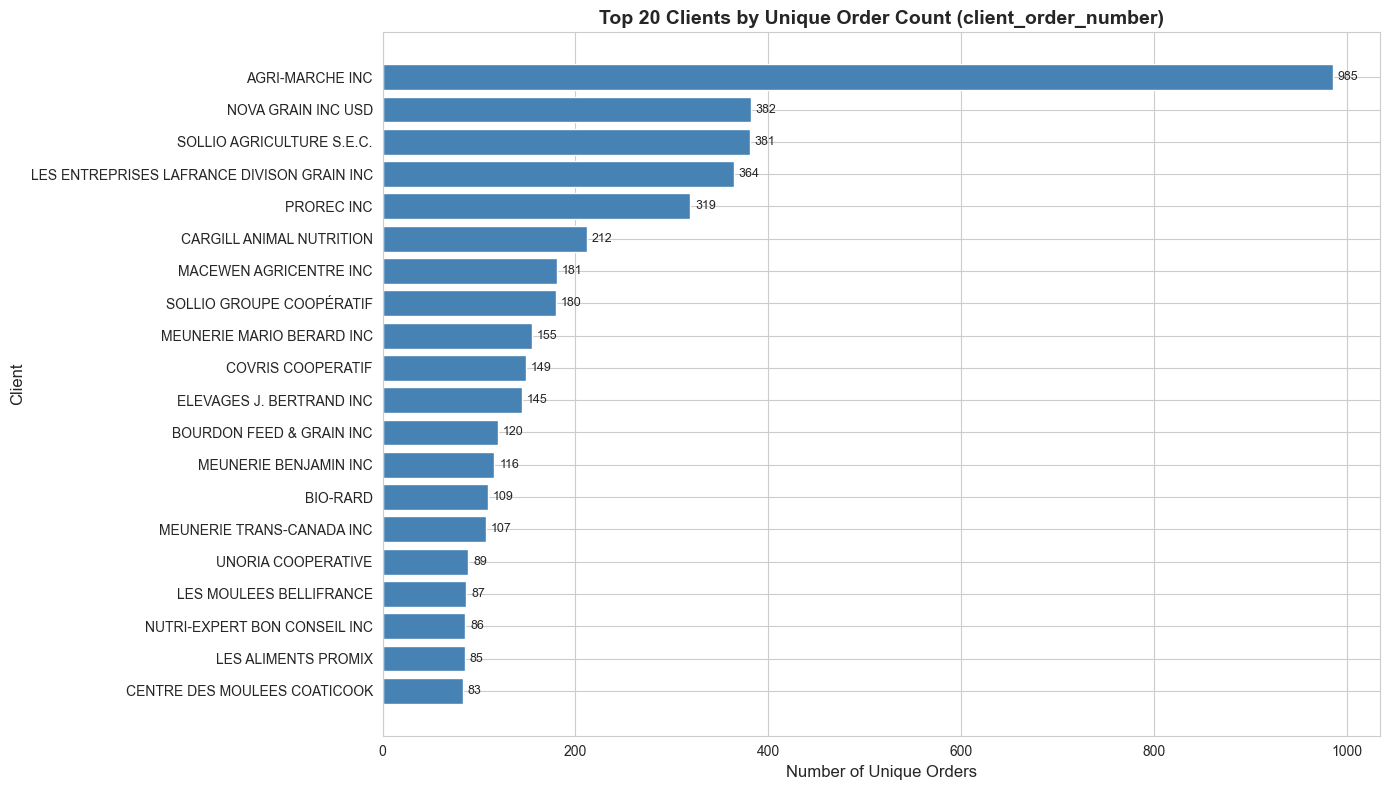

In [13]:
import matplotlib.pyplot as plt

# Visualize top clients by unique orders
plt.figure(figsize=(14, 8))
top_20_clients = df.groupby('client_name')['client_order_number'].nunique().sort_values(ascending=False).head(20)
bars = plt.barh(range(len(top_20_clients)), top_20_clients.values, color='steelblue')
plt.yticks(range(len(top_20_clients)), top_20_clients.index, fontsize=10)
plt.xlabel('Number of Unique Orders', fontsize=12)
plt.ylabel('Client', fontsize=12)
plt.title('Top 20 Clients by Unique Order Count (client_order_number)', fontsize=14, fontweight='bold')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_20_clients.values)):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
            f'{val:,}', va='center', fontsize=9)

plt.gca().invert_yaxis()  # Show highest at top
plt.tight_layout()
plt.show()

In [14]:
# Aggregate data by unique client_order_number
print("ORDER AMOUNT ANALYSIS BY CLIENT")
print("="*80)

# Group by client and client_order_number to get one row per unique order
order_summary = df.groupby(['client_name', 'client_order_number']).agg({
    'total_amount_ordered_tm': 'first',  # Take first value since it's the same for each order
    'product_name': 'first'
}).reset_index()

# Calculate statistics per client
client_stats = order_summary.groupby('client_name').agg({
    'total_amount_ordered_tm': ['mean', 'min', 'max', 'count'],
    'product_name': 'nunique'
}).reset_index()

# Flatten column names
client_stats.columns = ['client_name', 'avg_order_amount_tm', 'min_order_amount_tm', 
                        'max_order_amount_tm', 'total_orders', 'unique_products']

# Sort by total orders
client_stats = client_stats.sort_values('total_orders', ascending=False)

print(f"\nTop 20 clients - Order Amount Statistics:\n")
display(client_stats.head(20))

ORDER AMOUNT ANALYSIS BY CLIENT

Top 20 clients - Order Amount Statistics:



,client_name,avg_order_amount_tm,min_order_amount_tm,max_order_amount_tm,total_orders,unique_products
6,AGRI-MARCHE INC,43.719259,2.00,608.000,985,6
208,NOVA GRAIN INC USD,20.338976,16.00,24.000,382,1
175,LES ENTREPRISES LAFRANCE DIVISON GRAIN INC,5.521298,2.00,50.000,362,6
223,PROREC INC,15.014169,10.00,25.000,319,4
233,SOLLIO AGRICULTURE S.E.C.,7.836007,1.00,37.000,283,16
182,MACEWEN AGRICENTRE INC,22.009448,3.00,84.430,181,2
25,CARGILL ANIMAL NUTRITION,15.992486,2.00,50.210,177,4
194,MEUNERIE MARIO BERARD INC,29.437290,3.00,418.000,155,2
234,SOLLIO GROUPE COOPÉRATIF,7.471026,2.00,66.165,151,11
42,ELEVAGES J. BERTRAND INC,31.853517,2.00,700.000,145,3


In [15]:
# Find most and least ordered products by each client
print("\n" + "="*80)
print("PRODUCT ANALYSIS BY CLIENT")
print("="*80)

# Count product orders per client
product_by_client = order_summary.groupby(['client_name', 'product_name']).size().reset_index(name='order_count')

# Get most ordered product per client
most_ordered = product_by_client.loc[product_by_client.groupby('client_name')['order_count'].idxmax()]
most_ordered = most_ordered.rename(columns={'product_name': 'most_ordered_product', 
                                             'order_count': 'most_ordered_count'})

# Get least ordered product per client
least_ordered = product_by_client.loc[product_by_client.groupby('client_name')['order_count'].idxmin()]
least_ordered = least_ordered.rename(columns={'product_name': 'least_ordered_product', 
                                               'order_count': 'least_ordered_count'})

# Merge with client stats
client_product_stats = client_stats.merge(
    most_ordered[['client_name', 'most_ordered_product', 'most_ordered_count']], 
    on='client_name', how='left'
).merge(
    least_ordered[['client_name', 'least_ordered_product', 'least_ordered_count']], 
    on='client_name', how='left'
)

print(f"\nTop 20 clients - Complete Statistics:\n")
display(client_product_stats.head(20))


PRODUCT ANALYSIS BY CLIENT

Top 20 clients - Complete Statistics:



,client_name,avg_order_amount_tm,min_order_amount_tm,max_order_amount_tm,total_orders,unique_products,most_ordered_product,most_ordered_count,least_ordered_product,least_ordered_count
0,AGRI-MARCHE INC,43.719259,2.00,608.000,985,6,Trituro 44 - Fin,610,Trituro 46 Biologique,2
1,NOVA GRAIN INC USD,20.338976,16.00,24.000,382,1,Huile de Soya,382,Huile de Soya,382
2,LES ENTREPRISES LAFRANCE DIVISON GRAIN INC,5.521298,2.00,50.000,362,6,Trituro Laitier - Régulier,287,Trituro Laitier - FIN - 1000kg sac,1
3,PROREC INC,15.014169,10.00,25.000,319,4,Excel Profibre,160,Huile de Soya,3
4,SOLLIO AGRICULTURE S.E.C.,7.836007,1.00,37.000,283,16,Trituro Laitier - Régulier,89,Huile de Soya - BARIL 50KG,1
5,MACEWEN AGRICENTRE INC,22.009448,3.00,84.430,181,2,Huile de Soya,95,Trituro 44 - Régulier,86
6,CARGILL ANIMAL NUTRITION,15.992486,2.00,50.210,177,4,Huile de Soya,177,Huile de soya - BARIL 192kg,2
7,MEUNERIE MARIO BERARD INC,29.437290,3.00,418.000,155,2,Trituro 44 - Régulier,91,Huile de Soya,64
8,SOLLIO GROUPE COOPÉRATIF,7.471026,2.00,66.165,151,11,Trituro Laitier Biologique,51,Huile de Soya - BARIL 50KG,1
9,ELEVAGES J. BERTRAND INC,31.853517,2.00,700.000,145,3,Huile de Soya,72,Écales de Soya - Moulu,13


<Figure size 1600x1000 with 0 Axes>

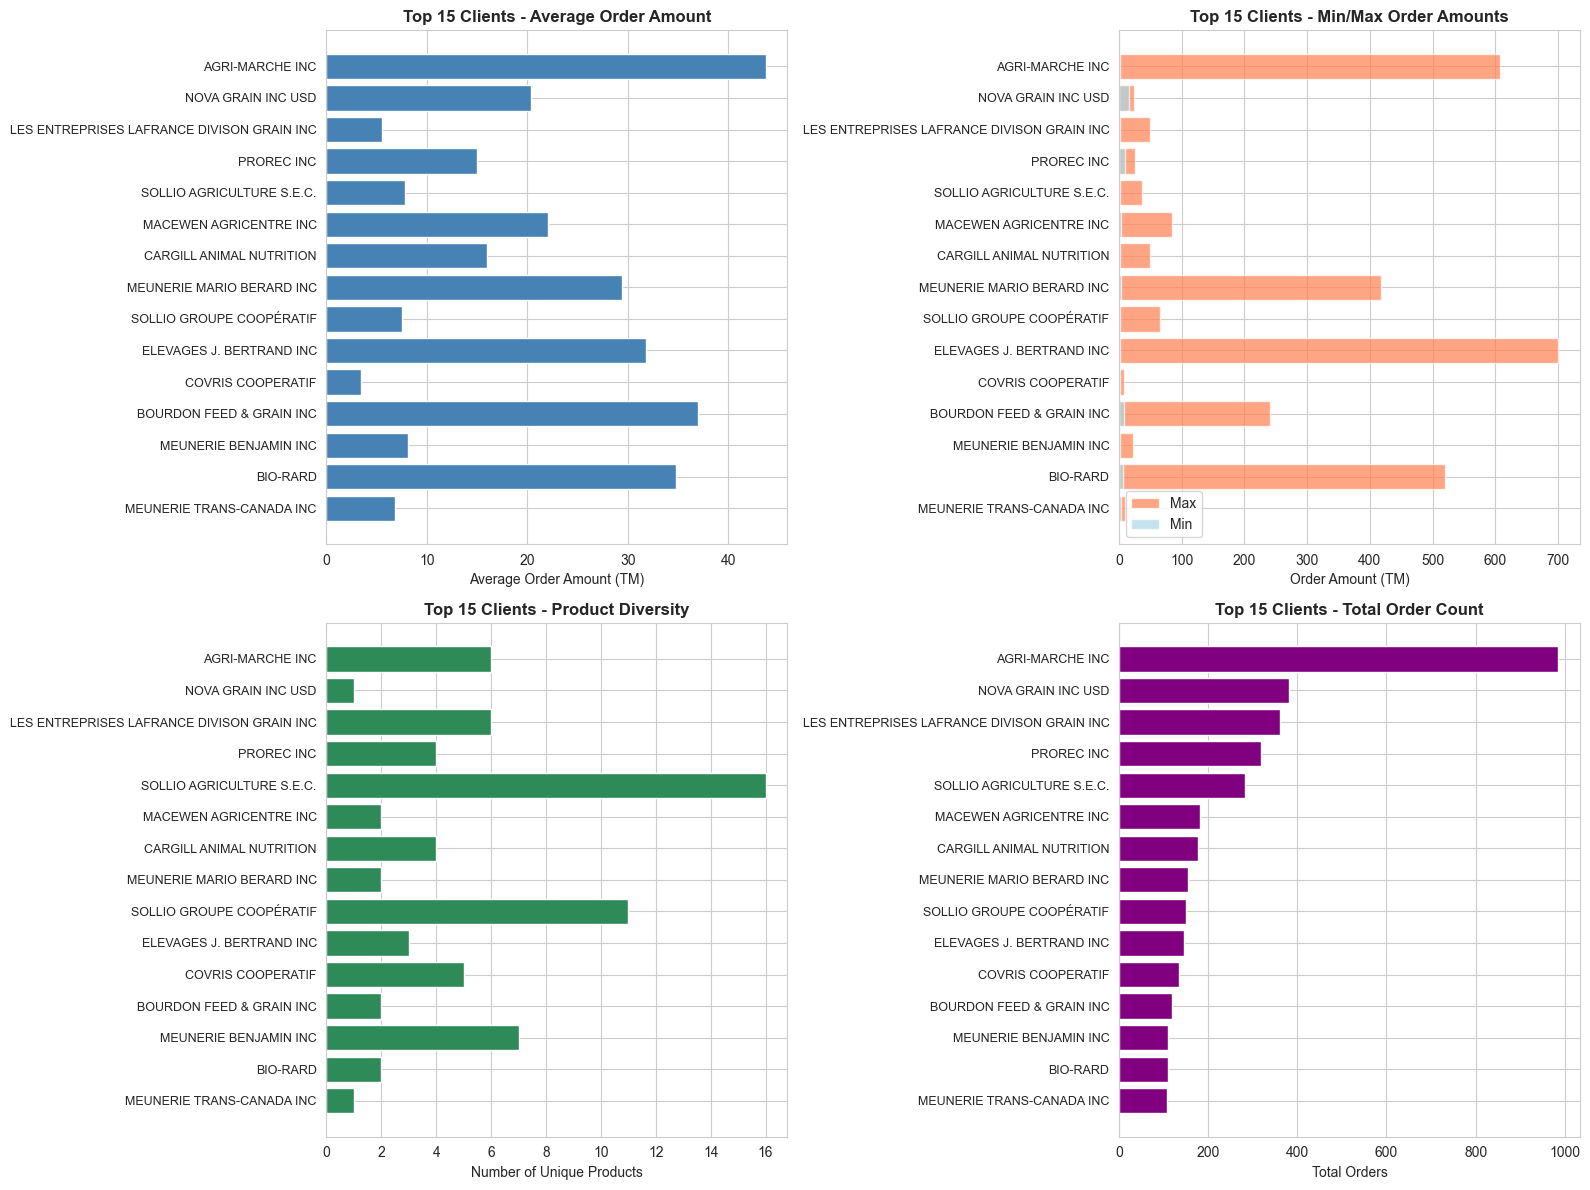

In [16]:
# Visualize order amount distribution for top clients
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

# Top 10 clients
top_10_clients = client_stats.head(10)['client_name'].tolist()

# Filter data for top 10 clients
top_clients_data = order_summary[order_summary['client_name'].isin(top_10_clients)]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Average order amount
ax1 = axes[0, 0]
avg_amounts = client_stats.head(15)[['client_name', 'avg_order_amount_tm']]
bars1 = ax1.barh(range(len(avg_amounts)), avg_amounts['avg_order_amount_tm'], color='steelblue')
ax1.set_yticks(range(len(avg_amounts)))
ax1.set_yticklabels(avg_amounts['client_name'], fontsize=9)
ax1.set_xlabel('Average Order Amount (TM)', fontsize=10)
ax1.set_title('Top 15 Clients - Average Order Amount', fontsize=12, fontweight='bold')
ax1.invert_yaxis()

# 2. Min/Max order amounts
ax2 = axes[0, 1]
top_15 = client_stats.head(15)
x = range(len(top_15))
ax2.barh(x, top_15['max_order_amount_tm'], label='Max', alpha=0.7, color='coral')
ax2.barh(x, top_15['min_order_amount_tm'], label='Min', alpha=0.7, color='lightblue')
ax2.set_yticks(x)
ax2.set_yticklabels(top_15['client_name'], fontsize=9)
ax2.set_xlabel('Order Amount (TM)', fontsize=10)
ax2.set_title('Top 15 Clients - Min/Max Order Amounts', fontsize=12, fontweight='bold')
ax2.legend()
ax2.invert_yaxis()

# 3. Number of unique products
ax3 = axes[1, 0]
products = client_stats.head(15)[['client_name', 'unique_products']]
bars3 = ax3.barh(range(len(products)), products['unique_products'], color='seagreen')
ax3.set_yticks(range(len(products)))
ax3.set_yticklabels(products['client_name'], fontsize=9)
ax3.set_xlabel('Number of Unique Products', fontsize=10)
ax3.set_title('Top 15 Clients - Product Diversity', fontsize=12, fontweight='bold')
ax3.invert_yaxis()

# 4. Total orders
ax4 = axes[1, 1]
orders = client_stats.head(15)[['client_name', 'total_orders']]
bars4 = ax4.barh(range(len(orders)), orders['total_orders'], color='purple')
ax4.set_yticks(range(len(orders)))
ax4.set_yticklabels(orders['client_name'], fontsize=9)
ax4.set_xlabel('Total Orders', fontsize=10)
ax4.set_title('Top 15 Clients - Total Order Count', fontsize=12, fontweight='bold')
ax4.invert_yaxis()

plt.tight_layout()
plt.show()

In [17]:
# Total amount per unique order for each client's most ordered product
print("="*80)
print("ANALYSIS: ORDER AMOUNTS FOR MOST ORDERED PRODUCT BY CLIENT")
print("="*80)

# Get unique orders
order_summary = df.groupby(['client_name', 'client_order_number']).agg({
    'total_amount_ordered_tm': 'first',
    'product_name': 'first',
    'sales_order_creation_date': 'first'
}).reset_index()

# Get most ordered product per client
product_by_client = order_summary.groupby(['client_name', 'product_name']).size().reset_index(name='order_count')
most_ordered_product = product_by_client.loc[product_by_client.groupby('client_name')['order_count'].idxmax()]
most_ordered_product = most_ordered_product[['client_name', 'product_name']].rename(
    columns={'product_name': 'most_ordered_product'}
)

# Filter orders for most ordered product only
orders_most_product = order_summary.merge(most_ordered_product, on='client_name')
orders_most_product = orders_most_product[
    orders_most_product['product_name'] == orders_most_product['most_ordered_product']
]

# Calculate statistics for most ordered product
client_most_product_stats = orders_most_product.groupby('client_name').agg({
    'total_amount_ordered_tm': ['mean', 'min', 'max', 'std', 'count'],
    'most_ordered_product': 'first'
}).reset_index()

client_most_product_stats.columns = ['client_name', 'avg_amount_tm', 'min_amount_tm', 
                                      'max_amount_tm', 'std_amount_tm', 'order_count', 
                                      'most_ordered_product']

# Sort by order count
client_most_product_stats = client_most_product_stats.sort_values('order_count', ascending=False)

print(f"\nTop 20 Clients - Statistics for Their Most Ordered Product:\n")
display(client_most_product_stats.head(20))

# Calculate coefficient of variation (CV) for order consistency
client_most_product_stats['cv_amount'] = (
    client_most_product_stats['std_amount_tm'] / client_most_product_stats['avg_amount_tm'] * 100
)

print(f"\nOrder Amount Consistency (Coefficient of Variation):")
print(f"  - Low CV (<20%) = Highly consistent order amounts")
print(f"  - Medium CV (20-50%) = Moderately consistent")
print(f"  - High CV (>50%) = Highly variable order amounts\n")

print("Top 10 Most Consistent Clients (Lowest CV):")
display(client_most_product_stats.nsmallest(10, 'cv_amount')[
    ['client_name', 'most_ordered_product', 'avg_amount_tm', 'cv_amount', 'order_count']
])

ANALYSIS: ORDER AMOUNTS FOR MOST ORDERED PRODUCT BY CLIENT

Top 20 Clients - Statistics for Their Most Ordered Product:



,client_name,avg_amount_tm,min_amount_tm,max_amount_tm,std_amount_tm,order_count,most_ordered_product
6,AGRI-MARCHE INC,48.356656,20.00,608.00,36.831569,610,Trituro 44 - Fin
208,NOVA GRAIN INC USD,20.338976,16.00,24.00,1.311609,382,Huile de Soya
175,LES ENTREPRISES LAFRANCE DIVISON GRAIN INC,4.826098,2.00,50.00,4.425779,287,Trituro Laitier - Régulier
25,CARGILL ANIMAL NUTRITION,15.992486,2.00,50.21,11.500678,177,Huile de Soya
223,PROREC INC,14.984500,12.00,15.74,0.302053,160,Excel Profibre
34,COVRIS COOPERATIF,3.433360,1.02,8.12,1.325034,125,Trituro Laitier Biologique
199,MEUNERIE TRANS-CANADA INC,6.810374,4.00,10.00,1.462489,107,Huile de Soya
182,MACEWEN AGRICENTRE INC,7.766737,3.00,25.00,4.394317,95,Huile de Soya
21,BOURDON FEED & GRAIN INC,29.874787,8.21,151.67,26.004193,94,Huile de Soya
194,MEUNERIE MARIO BERARD INC,44.846813,30.00,418.00,41.276257,91,Trituro 44 - Régulier



Order Amount Consistency (Coefficient of Variation):
  - Low CV (<20%) = Highly consistent order amounts
  - Medium CV (20-50%) = Moderately consistent
  - High CV (>50%) = Highly variable order amounts

Top 10 Most Consistent Clients (Lowest CV):


,client_name,most_ordered_product,avg_amount_tm,cv_amount,order_count
201,MOULEE VALLEE INC,Huile de Soya,3.0,0.0,20
41,ELEVAGE ET GRAIN GELE INC,Huile de Soya,3.0,0.0,7
37,E STAR RANCH,Huile de Soya,1.0,0.0,5
222,PICARDIE INTERNATIONAL,Huile de Soya,3.0,0.0,5
207,NOVA GRAIN INC CAD,"Trituro ""PROJET SANS OGM VÉRIFIÉ""",25.0,0.0,4
224,RAYMER GROUP INC.,Huile de Soya,68.0,0.0,3
54,FERME BELVUE SENC,Trituro 46 Biologique,6.0,0.0,2
49,FERME ALASKA INC,Trituro Laitier Biologique,4.0,0.0,2
7,AGRI-MEGA INC,Trituro Laitier - Régulier,23.0,0.0,2
102,FERME LAITIER D'ARGENTEUIL,Trituro Laitier - Régulier,2.0,0.0,2


In [18]:
# Prepare temporal data for consistency analysis
print("="*80)
print("TEMPORAL DATA PREPARATION")
print("="*80)

# Convert date to datetime
order_summary['order_date'] = pd.to_datetime(order_summary['sales_order_creation_date'])

# Extract temporal features
order_summary['year'] = order_summary['order_date'].dt.year
order_summary['month'] = order_summary['order_date'].dt.month
order_summary['year_month'] = order_summary['order_date'].dt.to_period('M')
order_summary['week'] = order_summary['order_date'].dt.isocalendar().week
order_summary['year_week'] = order_summary['order_date'].dt.to_period('W')

# Calculate bi-weekly periods (every 2 weeks)
order_summary['biweek'] = ((order_summary['order_date'].dt.dayofyear - 1) // 14) + 1
order_summary['year_biweek'] = order_summary['year'].astype(str) + '-BW' + order_summary['biweek'].astype(str)

# Data range
print(f"\nData Range:")
print(f"  - Start: {order_summary['order_date'].min()}")
print(f"  - End: {order_summary['order_date'].max()}")
print(f"  - Years covered: {sorted(order_summary['year'].unique())}")

# Orders per year
print(f"\nOrders per Year:")
year_counts = order_summary['year'].value_counts().sort_index()
for year, count in year_counts.items():
    print(f"  - {year}: {count:,} orders")

TEMPORAL DATA PREPARATION

Data Range:
  - Start: 2023-01-03 00:00:00
  - End: 2025-09-16 00:00:00
  - Years covered: [np.int32(2023), np.int32(2024), np.int32(2025)]

Orders per Year:
  - 2023: 2,544 orders
  - 2024: 2,615 orders
  - 2025: 1,730 orders


In [19]:
# Yearly consistency analysis (2023-2025)
print("="*80)
print("YEARLY ORDER CONSISTENCY (2023-2025)")
print("="*80)

# Count orders per client per year
yearly_orders = order_summary.groupby(['client_name', 'year']).agg({
    'client_order_number': 'count',
    'total_amount_ordered_tm': 'sum'
}).reset_index()
yearly_orders.columns = ['client_name', 'year', 'order_count', 'total_amount_tm']

# Pivot to show years as columns
yearly_pivot = yearly_orders.pivot(index='client_name', columns='year', values='order_count').fillna(0)
yearly_amount_pivot = yearly_orders.pivot(index='client_name', columns='year', values='total_amount_tm').fillna(0)

# Store the year columns before adding calculated columns
year_columns = yearly_pivot.columns.tolist()
print(f"\nYear columns in dataset: {year_columns}")

# Calculate consistency metrics
yearly_pivot['total_orders'] = yearly_pivot[year_columns].sum(axis=1)
yearly_pivot['years_active'] = (yearly_pivot[year_columns] > 0).sum(axis=1)  # FIXED: Only count year columns
yearly_pivot['avg_orders_per_year'] = yearly_pivot['total_orders'] / yearly_pivot['years_active']
yearly_pivot['std_orders_per_year'] = yearly_pivot[year_columns].std(axis=1)  # FIXED: Only use year columns
yearly_pivot['cv_orders_per_year'] = (yearly_pivot['std_orders_per_year'] / yearly_pivot['avg_orders_per_year'] * 100)

# Sort by total orders
yearly_pivot = yearly_pivot.sort_values('total_orders', ascending=False)

print(f"\nTop 20 Clients - Yearly Order Pattern:\n")
display(yearly_pivot.head(20))

# Identify most consistent clients (active all years with low CV)
all_years = len(year_columns)
print(f"\nTotal years in dataset: {all_years}")

consistent_clients = yearly_pivot[
    (yearly_pivot['years_active'] == all_years) 
    & 
    (yearly_pivot['cv_orders_per_year'] < 50)
].sort_values('cv_orders_per_year')

print(f"\n\nMost Consistent Clients (Active all {all_years} years with CV < 50%):")
print(f"Found {len(consistent_clients)} clients")
if len(consistent_clients) > 0:
    display(consistent_clients.head(10))

YEARLY ORDER CONSISTENCY (2023-2025)

Year columns in dataset: [2023, 2024, 2025]

Top 20 Clients - Yearly Order Pattern:



year,2023,2024,2025,total_orders,years_active,avg_orders_per_year,std_orders_per_year,cv_orders_per_year
client_name,,,,,,,,
AGRI-MARCHE INC,223.0,455.0,307.0,985.0,3,328.333333,117.462051,35.775244
NOVA GRAIN INC USD,147.0,139.0,96.0,382.0,3,127.333333,27.428695,21.540860
SOLLIO AGRICULTURE S.E.C.,201.0,179.0,1.0,381.0,3,127.000000,109.672239,86.356094
LES ENTREPRISES LAFRANCE DIVISON GRAIN INC,37.0,161.0,166.0,364.0,3,121.333333,73.077584,60.228778
PROREC INC,132.0,118.0,69.0,319.0,3,106.333333,33.080709,31.110385
CARGILL ANIMAL NUTRITION,63.0,94.0,55.0,212.0,3,70.666667,20.599353,29.150027
MACEWEN AGRICENTRE INC,55.0,70.0,56.0,181.0,3,60.333333,8.386497,13.900271
SOLLIO GROUPE COOPÉRATIF,0.0,39.0,141.0,180.0,2,90.000000,72.807967,80.897741
MEUNERIE MARIO BERARD INC,58.0,64.0,33.0,155.0,3,51.666667,16.441817,31.822871



Total years in dataset: 3


Most Consistent Clients (Active all 3 years with CV < 50%):
Found 57 clients


year,2023,2024,2025,total_orders,years_active,avg_orders_per_year,std_orders_per_year,cv_orders_per_year
client_name,,,,,,,,
MEUNERIE BERTHIAUME,9.0,9.0,9.0,27.0,3,9.000000,0.00000,0.000000
FERME MARIERRE INC,1.0,1.0,1.0,3.0,3,1.000000,0.00000,0.000000
BOUCHARD 1761 INC,1.0,1.0,1.0,3.0,3,1.000000,0.00000,0.000000
LES FERMES SAINT-VINCENT,1.0,1.0,1.0,3.0,3,1.000000,0.00000,0.000000
EAST COAST GRAINS INC.,1.0,1.0,1.0,3.0,3,1.000000,0.00000,0.000000
FERME MIBELSON,2.0,2.0,2.0,6.0,3,2.000000,0.00000,0.000000
FERME BEDARD ET FILS INC,2.0,2.0,2.0,6.0,3,2.000000,0.00000,0.000000
FERME LES PRODUITS D'ANTOINE,5.0,6.0,5.0,16.0,3,5.333333,0.57735,10.825318
FERME FABEL,5.0,6.0,5.0,16.0,3,5.333333,0.57735,10.825318


In [20]:
# Monthly consistency analysis
print("="*80)
print("MONTHLY ORDER CONSISTENCY")
print("="*80)

# Count orders per client per month
monthly_orders = order_summary.groupby(['client_name', 'year_month']).agg({
    'client_order_number': 'count',
    'total_amount_ordered_tm': 'sum'
}).reset_index()
monthly_orders.columns = ['client_name', 'year_month', 'order_count', 'total_amount_tm']

# Calculate monthly statistics per client
monthly_stats = monthly_orders.groupby('client_name').agg({
    'order_count': ['mean', 'std', 'min', 'max', 'count'],
    'total_amount_tm': ['mean', 'std']
}).reset_index()

monthly_stats.columns = ['client_name', 'avg_orders_per_month', 'std_orders_per_month', 
                         'min_orders_per_month', 'max_orders_per_month', 'months_active',
                         'avg_amount_per_month', 'std_amount_per_month']

# Calculate coefficient of variation
monthly_stats['cv_orders'] = (monthly_stats['std_orders_per_month'] / monthly_stats['avg_orders_per_month'] * 100)
monthly_stats['cv_amount'] = (monthly_stats['std_amount_per_month'] / monthly_stats['avg_amount_per_month'] * 100)

# Sort by months active and consistency
monthly_stats = monthly_stats.sort_values('months_active', ascending=False)

print(f"\nTop 20 Clients - Monthly Consistency:\n")
display(monthly_stats.head(20))

# Most consistent monthly clients
print(f"\n\nTop 10 Most Consistent Monthly Clients (Lowest CV, min 12 months):")
consistent_monthly = monthly_stats[monthly_stats['months_active'] >= 12].nsmallest(10, 'cv_orders')
display(consistent_monthly)

MONTHLY ORDER CONSISTENCY

Top 20 Clients - Monthly Consistency:



,client_name,avg_orders_per_month,std_orders_per_month,min_orders_per_month,max_orders_per_month,months_active,avg_amount_per_month,std_amount_per_month,cv_orders,cv_amount
6,AGRI-MARCHE INC,29.848485,12.002919,14,55,33,1304.953636,313.124348,40.212827,23.995055
25,CARGILL ANIMAL NUTRITION,6.424242,1.968983,2,10,33,85.777879,23.689360,30.649263,27.617097
199,MEUNERIE TRANS-CANADA INC,3.242424,1.521313,1,7,33,22.082121,10.591605,46.919006,47.964619
223,PROREC INC,9.666667,2.965074,2,14,33,145.136970,44.629200,30.673184,30.749712
194,MEUNERIE MARIO BERARD INC,4.696970,1.610218,1,8,33,138.266061,94.597426,34.282067,68.416953
208,NOVA GRAIN INC USD,11.575758,1.887960,5,15,33,235.439061,36.837560,16.309604,15.646325
172,LES ALIMENTS PROMIX,2.575758,0.969223,1,5,33,18.550909,6.726736,37.628672,36.260953
184,MEUNERIE BENJAMIN INC,3.515152,1.622521,1,7,33,27.211212,12.732812,46.157937,46.792521
193,MEUNERIE HEBERT INC,1.437500,0.715609,1,3,32,14.350938,32.153143,49.781522,224.049075
182,MACEWEN AGRICENTRE INC,5.656250,2.522280,2,12,32,124.490938,122.911269,44.592791,98.731097




Top 10 Most Consistent Monthly Clients (Lowest CV, min 12 months):


,client_name,avg_orders_per_month,std_orders_per_month,min_orders_per_month,max_orders_per_month,months_active,avg_amount_per_month,std_amount_per_month,cv_orders,cv_amount
123,FERME MAXIE NORD INC,1.0,0.0,1,1,24,4.165833,0.599441,0.0,14.389466
66,FERME CHRETIEN,1.0,0.0,1,1,21,26.995238,4.398068,0.0,16.292016
115,FERME LORAYBEL SENC,1.0,0.0,1,1,18,3.981667,0.625735,0.0,15.715400
110,FERME LE CREPUSCULE,1.0,0.0,1,1,18,0.000000,0.000000,0.0,NaN
9,AGRICOMAX/9332-9860 QUEBEC INC,1.0,0.0,1,1,17,31.294118,2.910428,0.0,9.300238
77,FERME FABEL,1.0,0.0,1,1,16,7.337500,1.875880,0.0,25.565659
82,FERME FREDERIC CHOLLET,1.0,0.0,1,1,13,4.026154,0.033798,0.0,0.839462
131,FERME OLFELY INC,1.0,0.0,1,1,13,4.500769,2.318094,0.0,51.504386
145,FERME SYMA SENC,1.0,0.0,1,1,13,5.407692,1.054294,0.0,19.496191
16,BERTRAND BRODEUR /9231-1901 QUEBEC INC,1.0,0.0,1,1,12,25.840000,23.355156,0.0,90.383729


In [21]:
# Bi-weekly consistency analysis
print("="*80)
print("BI-WEEKLY ORDER CONSISTENCY")
print("="*80)

# Count orders per client per bi-week
biweekly_orders = order_summary.groupby(['client_name', 'year_biweek']).agg({
    'client_order_number': 'count',
    'total_amount_ordered_tm': 'sum'
}).reset_index()
biweekly_orders.columns = ['client_name', 'year_biweek', 'order_count', 'total_amount_tm']

# Calculate bi-weekly statistics per client
biweekly_stats = biweekly_orders.groupby('client_name').agg({
    'order_count': ['mean', 'std', 'min', 'max', 'count'],
    'total_amount_tm': ['mean', 'std']
}).reset_index()

biweekly_stats.columns = ['client_name', 'avg_orders_per_biweek', 'std_orders_per_biweek', 
                          'min_orders_per_biweek', 'max_orders_per_biweek', 'biweeks_active',
                          'avg_amount_per_biweek', 'std_amount_per_biweek']

# Calculate coefficient of variation
biweekly_stats['cv_orders'] = (biweekly_stats['std_orders_per_biweek'] / biweekly_stats['avg_orders_per_biweek'] * 100)
biweekly_stats['cv_amount'] = (biweekly_stats['std_amount_per_biweek'] / biweekly_stats['avg_amount_per_biweek'] * 100)

# Sort by biweeks active
biweekly_stats = biweekly_stats.sort_values('biweeks_active', ascending=False)

print(f"\nTop 20 Clients - Bi-weekly Consistency:\n")
display(biweekly_stats.head(20))

# Most consistent bi-weekly clients
print(f"\n\nTop 10 Most Consistent Bi-weekly Clients (Lowest CV, min 24 bi-weeks):")
consistent_biweekly = biweekly_stats[biweekly_stats['biweeks_active'] >= 24].nsmallest(10, 'cv_orders')
display(consistent_biweekly)

BI-WEEKLY ORDER CONSISTENCY

Top 20 Clients - Bi-weekly Consistency:



,client_name,avg_orders_per_biweek,std_orders_per_biweek,min_orders_per_biweek,max_orders_per_biweek,biweeks_active,avg_amount_per_biweek,std_amount_per_biweek,cv_orders,cv_amount
6,AGRI-MARCHE INC,13.680556,6.236707,2,28,72,598.103750,209.523003,45.588114,35.031214
223,PROREC INC,4.492958,1.482018,1,8,71,67.458028,22.267722,32.985360,33.009744
25,CARGILL ANIMAL NUTRITION,3.028571,1.340251,1,7,70,40.438143,16.284053,44.253578,40.269042
208,NOVA GRAIN INC USD,5.457143,1.347953,3,8,70,110.992700,26.565709,24.700709,23.934645
182,MACEWEN AGRICENTRE INC,2.661765,1.441499,1,7,68,58.583971,61.136652,54.155762,104.357304
194,MEUNERIE MARIO BERARD INC,2.279412,0.990184,1,5,68,67.099706,59.539105,43.440352,88.732289
172,LES ALIMENTS PROMIX,1.268657,0.479333,1,3,67,9.137015,3.755575,37.782732,41.102869
17,BIO-RARD,1.730159,0.827089,1,4,63,60.235714,69.659430,47.804211,115.644732
199,MEUNERIE TRANS-CANADA INC,1.783333,0.761169,1,4,60,12.145167,5.843559,42.682384,48.114278
226,REAL MONDOU INC,1.116667,0.323732,1,2,60,5.000333,1.834905,28.990905,36.695662




Top 10 Most Consistent Bi-weekly Clients (Lowest CV, min 24 bi-weeks):


,client_name,avg_orders_per_biweek,std_orders_per_biweek,min_orders_per_biweek,max_orders_per_biweek,biweeks_active,avg_amount_per_biweek,std_amount_per_biweek,cv_orders,cv_amount
170,LAIT PORC M.C. INC,1.000000,0.000000,1,1,28,4.597500,3.848155,0.000000,83.701024
186,MEUNERIE BERTHIAUME,1.000000,0.000000,1,1,27,4.611111,0.655353,0.000000,14.212468
123,FERME MAXIE NORD INC,1.000000,0.000000,1,1,24,4.165833,0.599441,0.000000,14.389466
160,INDUSTRIE P.W.I. INC,1.034483,0.185695,1,2,29,6.458621,0.992658,17.950549,15.369501
171,LE PORC DU MOINE,1.040000,0.200000,1,2,25,27.682840,7.814197,19.230769,28.227585
202,MOULEES FAUBERT 2015 INC,1.040000,0.200000,1,2,25,26.568800,6.593585,19.230769,24.817024
201,MOULEE VALLEE INC,1.041667,0.204124,1,2,24,4.208333,2.963241,19.595918,70.413647
208,NOVA GRAIN INC USD,5.457143,1.347953,3,8,70,110.992700,26.565709,24.700709,23.934645
169,LACTECH INC,1.075000,0.266747,1,2,40,4.402000,5.681829,24.813654,129.073807
226,REAL MONDOU INC,1.116667,0.323732,1,2,60,5.000333,1.834905,28.990905,36.695662


In [22]:
# Weekly consistency analysis
print("="*80)
print("WEEKLY ORDER CONSISTENCY")
print("="*80)

# Count orders per client per week
weekly_orders = order_summary.groupby(['client_name', 'year_week']).agg({
    'client_order_number': 'count',
    'total_amount_ordered_tm': 'sum'
}).reset_index()
weekly_orders.columns = ['client_name', 'year_week', 'order_count', 'total_amount_tm']

# Calculate weekly statistics per client
weekly_stats = weekly_orders.groupby('client_name').agg({
    'order_count': ['mean', 'std', 'min', 'max', 'count'],
    'total_amount_tm': ['mean', 'std']
}).reset_index()

weekly_stats.columns = ['client_name', 'avg_orders_per_week', 'std_orders_per_week', 
                        'min_orders_per_week', 'max_orders_per_week', 'weeks_active',
                        'avg_amount_per_week', 'std_amount_per_week']

# Calculate coefficient of variation
weekly_stats['cv_orders'] = (weekly_stats['std_orders_per_week'] / weekly_stats['avg_orders_per_week'] * 100)
weekly_stats['cv_amount'] = (weekly_stats['std_amount_per_week'] / weekly_stats['avg_amount_per_week'] * 100)

# Sort by weeks active
weekly_stats = weekly_stats.sort_values('weeks_active', ascending=False)

print(f"\nTop 20 Clients - Weekly Consistency:\n")
display(weekly_stats.head(20))

# Most consistent weekly clients
print(f"\n\nTop 10 Most Consistent Weekly Clients (Lowest CV, min 48 weeks):")
consistent_weekly = weekly_stats[weekly_stats['weeks_active'] >= 48].nsmallest(10, 'cv_orders')
display(consistent_weekly)

WEEKLY ORDER CONSISTENCY

Top 20 Clients - Weekly Consistency:



,client_name,avg_orders_per_week,std_orders_per_week,min_orders_per_week,max_orders_per_week,weeks_active,avg_amount_per_week,std_amount_per_week,cv_orders,cv_amount
6,AGRI-MARCHE INC,7.035714,3.383010,1,24,140,307.596214,124.222832,48.083395,40.385033
208,NOVA GRAIN INC USD,2.748201,1.103969,1,6,139,55.895604,21.736167,40.170586,38.887077
223,PROREC INC,2.416667,1.011700,1,6,132,36.284242,15.447791,41.863448,42.574380
25,CARGILL ANIMAL NUTRITION,1.781513,0.966907,1,5,119,23.787143,11.633937,54.274509,48.908508
182,MACEWEN AGRICENTRE INC,1.630631,0.873113,1,4,111,35.889279,36.490434,53.544487,101.675026
194,MEUNERIE MARIO BERARD INC,1.550000,0.657129,1,3,100,45.627800,50.836467,42.395403,111.415557
199,MEUNERIE TRANS-CANADA INC,1.091837,0.323854,1,3,98,7.435816,2.883144,29.661354,38.773744
175,LES ENTREPRISES LAFRANCE DIVISON GRAIN INC,3.831579,2.019335,1,11,95,21.039053,26.978839,52.702436,128.232193
233,SOLLIO AGRICULTURE S.E.C.,4.053191,1.930887,1,11,94,23.591383,15.903885,47.638672,67.413960
21,BOURDON FEED & GRAIN INC,1.411765,0.622860,1,4,85,52.164941,58.339927,44.119284,111.837424




Top 10 Most Consistent Weekly Clients (Lowest CV, min 48 weeks):


,client_name,avg_orders_per_week,std_orders_per_week,min_orders_per_week,max_orders_per_week,weeks_active,avg_amount_per_week,std_amount_per_week,cv_orders,cv_amount
226,REAL MONDOU INC,1.030769,0.174036,1,2,65,4.615692,1.262721,16.884071,27.357142
211,NUTRI-EXPERT BON CONSEIL INC,1.036145,0.187784,1,2,83,7.797590,2.826837,18.123384,36.252702
212,NUTRINOR AGRICULTURE,1.068966,0.255609,1,2,58,44.651552,35.411029,23.911772,79.305259
172,LES ALIMENTS PROMIX,1.049383,0.269316,1,3,81,7.557778,2.981326,25.664187,39.447119
195,MEUNERIE R.M.R. INC,1.086957,0.283836,1,2,69,6.751580,2.934545,26.112877,43.464573
216,OLIER GRISE,1.100000,0.303046,1,2,50,0.000000,0.000000,27.549615,NaN
33,COOP AGRICOLE DE SAINT- BERNARD,1.101695,0.304841,1,2,59,10.112203,4.012353,27.670195,39.678329
199,MEUNERIE TRANS-CANADA INC,1.091837,0.323854,1,3,98,7.435816,2.883144,29.661354,38.773744
208,NOVA GRAIN INC USD,2.748201,1.103969,1,6,139,55.895604,21.736167,40.170586,38.887077
223,PROREC INC,2.416667,1.011700,1,6,132,36.284242,15.447791,41.863448,42.574380


In [ ]:
#Visualize temporal consistency patterns
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Select top 5 most active clients for visualization
top_clients = yearly_pivot.head(5).index.tolist()

# 1. Yearly trends
ax1 = axes[0, 0]
yearly_data = yearly_orders[yearly_orders['client_name'].isin(top_clients)]
for client in top_clients:
    client_data = yearly_data[yearly_data['client_name'] == client]
    ax1.plot(client_data['year'], client_data['order_count'], marker='o', label=client, linewidth=2)
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Number of Orders', fontsize=11)
ax1.set_title('Top 5 Clients - Yearly Order Trends', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Monthly trends (last 24 months)
ax2 = axes[0, 1]
monthly_data = monthly_orders[monthly_orders['client_name'].isin(top_clients)]
monthly_data = monthly_data.sort_values('year_month')
# Get last 24 months
last_24_months = monthly_data['year_month'].unique()[-24:]
monthly_data_recent = monthly_data[monthly_data['year_month'].isin(last_24_months)]

for client in top_clients:
    client_data = monthly_data_recent[monthly_data_recent['client_name'] == client]
    ax2.plot(range(len(client_data)), client_data['order_count'], marker='o', label=client, linewidth=2)
ax2.set_xlabel('Month (Last 24 months)', fontsize=11)
ax2.set_ylabel('Number of Orders', fontsize=11)
ax2.set_title('Top 5 Clients - Monthly Order Trends (Last 24 Months)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Order consistency comparison (CV across timeframes)
ax3 = axes[1, 0]
timeframes = ['Yearly', 'Monthly', 'Bi-weekly', 'Weekly']
# Get average CV for top 20 clients across timeframes
top_20_clients = yearly_pivot.head(20).index.tolist()

avg_cvs = [
    yearly_pivot.loc[yearly_pivot.index.isin(top_20_clients), 'cv_orders_per_year'].mean(),
    monthly_stats[monthly_stats['client_name'].isin(top_20_clients)]['cv_orders'].mean(),
    biweekly_stats[biweekly_stats['client_name'].isin(top_20_clients)]['cv_orders'].mean(),
    weekly_stats[weekly_stats['client_name'].isin(top_20_clients)]['cv_orders'].mean()
]

bars = ax3.bar(timeframes, avg_cvs, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax3.set_ylabel('Average Coefficient of Variation (%)', fontsize=11)
ax3.set_title('Order Consistency Across Timeframes\n(Top 20 Clients)', fontsize=13, fontweight='bold')
ax3.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='High variability threshold')
for i, (bar, val) in enumerate(zip(bars, avg_cvs)):
    ax3.text(i, val + 2, f'{val:.1f}%', ha='center', fontsize=10, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Distribution of active periods
ax4 = axes[1, 1]
activity_data = {
    'Years': yearly_pivot['years_active'].value_counts().sort_index(),
    'Months': monthly_stats['months_active'].value_counts().sort_index(),
}

x_pos = np.arange(len(activity_data['Years']))
width = 0.35

# Normalize to show percentage
total_clients = len(yearly_pivot)
years_pct = (activity_data['Years'] / total_clients * 100).values
months_bins = pd.cut(activity_data['Months'].index, bins=[0, 12, 24, 36, 48, 100], labels=['1-12', '13-24', '25-36', '37-48', '48+'])
months_grouped = activity_data['Months'].groupby(months_bins).sum()
months_pct = (months_grouped / total_clients * 100).values

ax4_twin = ax4.twinx()
bars1 = ax4.bar(range(len(activity_data['Years'])), years_pct, width, label='Years Active', color='steelblue', alpha=0.8)
bars2 = ax4_twin.bar(np.arange(len(months_grouped)) + 0.4, months_pct, width, label='Months Active (grouped)', color='coral', alpha=0.8)

ax4.set_xlabel('Activity Period', fontsize=11)
ax4.set_ylabel('Percentage of Clients - Years (%)', fontsize=10, color='steelblue')
ax4_twin.set_ylabel('Percentage of Clients - Months (%)', fontsize=10, color='coral')
ax4.set_title('Client Activity Distribution', fontsize=13, fontweight='bold')
ax4.set_xticks(range(max(len(activity_data['Years']), len(months_grouped))))
ax4.tick_params(axis='y', labelcolor='steelblue')
ax4_twin.tick_params(axis='y', labelcolor='coral')
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# CELL 8: Summary of consistency analysis
print("="*80)
print("CONSISTENCY ANALYSIS SUMMARY")
print("="*80)

# Overall consistency metrics
print("\n1. TEMPORAL GRANULARITY COMPARISON")
print("-" * 80)
print(f"{'Timeframe':<15} {'Avg CV':<12} {'High Consistency':<20} {'Med Consistency':<20}")
print("-" * 80)

def categorize_consistency(stats_df, cv_col):
    high = (stats_df[cv_col] < 20).sum()
    medium = ((stats_df[cv_col] >= 20) & (stats_df[cv_col] < 50)).sum()
    return high, medium

yearly_high, yearly_med = categorize_consistency(yearly_pivot, 'cv_orders_per_year')
monthly_high, monthly_med = categorize_consistency(monthly_stats, 'cv_orders')
biweekly_high, biweekly_med = categorize_consistency(biweekly_stats, 'cv_orders')
weekly_high, weekly_med = categorize_consistency(weekly_stats, 'cv_orders')

print(f"{'Yearly':<15} {yearly_pivot['cv_orders_per_year'].mean():<12.2f} {yearly_high:<20} {yearly_med:<20}")
print(f"{'Monthly':<15} {monthly_stats['cv_orders'].mean():<12.2f} {monthly_high:<20} {monthly_med:<20}")
print(f"{'Bi-weekly':<15} {biweekly_stats['cv_orders'].mean():<12.2f} {biweekly_high:<20} {biweekly_med:<20}")
print(f"{'Weekly':<15} {weekly_stats['cv_orders'].mean():<12.2f} {weekly_high:<20} {weekly_med:<20}")

print("\n\n2. CLIENT LOYALTY & RETENTION")
print("-" * 80)
print(f"Total unique clients: {len(yearly_pivot):,}")
print(f"Clients active in all {order_summary['year'].nunique()} years: {(yearly_pivot['years_active'] == order_summary['year'].nunique()).sum():,}")
print(f"Clients active 12+ months: {(monthly_stats['months_active'] >= 12).sum():,}")
print(f"Clients active 24+ months: {(monthly_stats['months_active'] >= 24).sum():,}")

print("\n\n3. RECOMMENDED PREDICTION TIMEFRAME")
print("-" * 80)
print("Based on consistency analysis:")
print(f"  → Monthly predictions appear most suitable (CV: {monthly_stats['cv_orders'].mean():.2f}%)")
print(f"  → {monthly_high} clients show high monthly consistency (CV < 20%)")
print(f"  → {(monthly_stats['months_active'] >= 12).sum():,} clients have 12+ months of history")

In [ ]:
# CELL: Investigate AGRI-MARCHE INC ordering patterns
print("="*80)
print("INVESTIGATION: AGRI-MARCHE INC ORDERING PATTERNS")
print("="*80)

client_to_investigate = "AGRI-MARCHE INC"

# Get all orders for this client
agri_orders = order_summary[order_summary['client_name'] == client_to_investigate].copy()
agri_orders = agri_orders.sort_values('order_date')

print(f"\nTotal unique orders for {client_to_investigate}: {len(agri_orders)}")
print(f"Date range: {agri_orders['order_date'].min()} to {agri_orders['order_date'].max()}")

# Check years active
print(f"\nYears active: {sorted(agri_orders['year'].unique())}")
print(f"Years count: {agri_orders['year'].nunique()}")

# Analyze weekly distribution
print("\n" + "-"*80)
print("WEEKLY ORDER DISTRIBUTION:")
print("-"*80)

weekly_distribution = agri_orders.groupby('year_week').agg({
    'client_order_number': 'count',
    'order_date': ['min', 'max']
}).reset_index()
weekly_distribution.columns = ['year_week', 'order_count', 'first_order', 'last_order']
weekly_distribution = weekly_distribution.sort_values('order_count', ascending=False)

print("\nTop 10 weeks with most orders:")
display(weekly_distribution.head(10))

# Find the week with 24+ orders
max_week = weekly_distribution.iloc[0]
print(f"\n\nWeek with maximum orders: {max_week['year_week']}")
print(f"Number of orders: {max_week['order_count']}")
print(f"Date range: {max_week['first_order']} to {max_week['last_order']}")

# Get details of that specific week
busy_week_orders = agri_orders[agri_orders['year_week'] == max_week['year_week']]
print(f"\n\nDetailed orders for week {max_week['year_week']}:")
display(busy_week_orders[['client_order_number', 'product_name', 'order_date', 
                          'total_amount_ordered_tm']].sort_values('order_date'))

In [ ]:
# CELL: Check for data quality issues - same order numbers appearing multiple times
print("="*80)
print("DATA QUALITY CHECK: DUPLICATE ORDER NUMBERS")
print("="*80)

# Check if the same client_order_number appears multiple times in order_summary
order_number_counts = order_summary.groupby(['client_name', 'client_order_number']).size().reset_index(name='count')
duplicates = order_number_counts[order_number_counts['count'] > 1]

print(f"\nTotal unique (client, order_number) combinations: {len(order_number_counts)}")
print(f"Combinations appearing more than once: {len(duplicates)}")

if len(duplicates) > 0:
    print("\n⚠️  WARNING: Found duplicate client_order_numbers in order_summary!")
    print("This suggests the aggregation in CELL 2 didn't work correctly.")
    print("\nTop 10 most duplicated orders:")
    display(duplicates.nlargest(10, 'count'))
    
    # Check AGRI-MARCHE INC specifically
    agri_duplicates = duplicates[duplicates['client_name'] == client_to_investigate]
    if len(agri_duplicates) > 0:
        print(f"\n{client_to_investigate} duplicate orders: {len(agri_duplicates)}")
        display(agri_duplicates.head(10))

In [ ]:
# CELL: Re-examine the original data for AGRI-MARCHE INC
print("="*80)
print("EXAMINING RAW DATA: AGRI-MARCHE INC")
print("="*80)

# Go back to original dataframe
agri_raw = df[df['client_name'] == client_to_investigate].copy()
agri_raw['order_date'] = pd.to_datetime(agri_raw['sales_order_creation_date'])

print(f"Total rows in raw data: {len(agri_raw)}")
print(f"Unique client_order_numbers: {agri_raw['client_order_number'].nunique()}")
print(f"Average rows per order: {len(agri_raw) / agri_raw['client_order_number'].nunique():.2f}")

# Check for orders with multiple expeditions
print("\n" + "-"*80)
print("ORDERS WITH MULTIPLE EXPEDITIONS:")
print("-"*80)

expedition_counts = agri_raw.groupby('client_order_number').size().reset_index(name='expedition_count')
multi_expedition = expedition_counts[expedition_counts['expedition_count'] > 1].sort_values('expedition_count', ascending=False)

print(f"\nOrders with multiple expeditions: {len(multi_expedition)}")
display(multi_expedition.head(10))

# Show example of a multi-expedition order
if len(multi_expedition) > 0:
    example_order = multi_expedition.iloc[0]['client_order_number']
    print(f"\n\nExample: Order {example_order} details:")
    example_data = agri_raw[agri_raw['client_order_number'] == example_order][
        ['client_order_number', 'expedition_number', 'product_name', 'order_date',
         'actual_expedition_date', 'total_amount_ordered_tm', 'total_amount_delivered_tm']
    ].sort_values('actual_expedition_date')
    display(example_data)

## 7. Product Analysis

In [ ]:
# CELL: Analyze products - Basic Statistics
print("="*80)
print("PRODUCT ANALYSIS - BASIC STATISTICS")
print("="*80)

print(f"Total unique products: {df['product_name'].nunique()}")
print(f"Total unique orders: {order_summary_corrected['client_order_number'].nunique()}")
print(f"Total expeditions (deliveries): {len(df)}")

# Product distribution based on UNIQUE ORDERS
print("\n" + "-"*80)
print("Product distribution by UNIQUE ORDERS:")
print("-"*80)

product_counts = order_summary_corrected['product_name'].value_counts()
product_df = pd.DataFrame({
    'Product': product_counts.index,
    'Unique_Order_Count': product_counts.values,
    'Percentage': (product_counts.values / len(order_summary_corrected) * 100).round(2)
})

# Add amount statistics
product_amount_stats = order_summary_corrected.groupby('product_name').agg({
    'total_amount_ordered_tm': ['sum', 'mean', 'std']
}).reset_index()
product_amount_stats.columns = ['Product', 'Total_TM', 'Avg_TM_per_Order', 'Std_TM']

# Merge
product_df = product_df.merge(product_amount_stats, on='Product')

# Add number of unique clients per product
product_clients = order_summary_corrected.groupby('product_name')['client_name'].nunique().reset_index()
product_clients.columns = ['Product', 'Unique_Clients']
product_df = product_df.merge(product_clients, on='Product')

# Sort by order count
product_df = product_df.sort_values('Unique_Order_Count', ascending=False)

print(f"\nComplete Product Statistics:")
display(product_df)

In [ ]:
# CELL: Product-Client Relationship Analysis
print("="*80)
print("PRODUCT-CLIENT RELATIONSHIP ANALYSIS")
print("="*80)

# Average orders per client per product
product_df['Avg_Orders_per_Client'] = product_df['Unique_Order_Count'] / product_df['Unique_Clients']

# Find products with high client concentration (few clients, many orders)
product_df['Client_Concentration'] = 1 / product_df['Unique_Clients']  # Higher = more concentrated

print("\nProducts ranked by client loyalty (Avg Orders per Client):")
display(product_df.sort_values('Avg_Orders_per_Client', ascending=False)[
    ['Product', 'Unique_Order_Count', 'Unique_Clients', 'Avg_Orders_per_Client', 'Percentage']
])

print("\n" + "-"*80)
print("Product Market Characteristics:")
print("-"*80)

for idx, row in product_df.iterrows():
    market_type = "Niche" if row['Client_Concentration'] > 0.01 else "Broad"
    loyalty = "High Loyalty" if row['Avg_Orders_per_Client'] > 20 else "Low Loyalty"
    print(f"{row['Product']:40s} | {market_type:8s} | {loyalty:12s} | "
          f"{row['Unique_Clients']:3.0f} clients, {row['Avg_Orders_per_Client']:.1f} orders/client")

In [ ]:
# CELL: Product Temporal Analysis
print("="*80)
print("PRODUCT TEMPORAL ANALYSIS - TRENDS OVER TIME")
print("="*80)

# Product orders by year
product_yearly = order_summary_corrected.groupby(['product_name', 'year']).size().reset_index(name='order_count')
product_yearly_pivot = product_yearly.pivot(index='product_name', columns='year', values='order_count').fillna(0)

print("\nProduct Orders by Year:")
display(product_yearly_pivot)

# Calculate growth rates
year_cols = sorted([col for col in product_yearly_pivot.columns if isinstance(col, (int, float))])
if len(year_cols) >= 2:
    product_yearly_pivot['Growth_Rate_%'] = (
        (product_yearly_pivot[year_cols[-1]] - product_yearly_pivot[year_cols[0]]) / 
        (product_yearly_pivot[year_cols[0]].replace(0, 1)) * 100
    )
    
    print(f"\n\nProduct Growth from {year_cols[0]} to {year_cols[-1]}:")
    growth_df = product_yearly_pivot[['Growth_Rate_%']].sort_values('Growth_Rate_%', ascending=False)
    display(growth_df)
    
    # Categorize products
    print("\n" + "-"*80)
    print("Product Lifecycle Categories:")
    print("-"*80)
    for product in product_yearly_pivot.index:
        growth = product_yearly_pivot.loc[product, 'Growth_Rate_%']
        if growth > 50:
            category = "🚀 Growing"
        elif growth > 0:
            category = "📈 Stable Growth"
        elif growth > -25:
            category = "📊 Stable"
        else:
            category = "📉 Declining"
        print(f"{product:40s} | {category:15s} | {growth:+6.1f}%")

In [ ]:
# CELL: Visualize product distribution with enhanced insights
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Bar chart - Orders by Product
ax1 = axes[0, 0]
bars = ax1.barh(range(len(product_df)), product_df['Unique_Order_Count'], color='teal')
ax1.set_yticks(range(len(product_df)))
ax1.set_yticklabels(product_df['Product'], fontsize=10)
ax1.set_xlabel('Number of Unique Orders', fontsize=11)
ax1.set_title('Orders by Product Type', fontsize=13, fontweight='bold')
ax1.invert_yaxis()

for i, (bar, val) in enumerate(zip(bars, product_df['Unique_Order_Count'].values)):
    ax1.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, 
            f'{val:,}', va='center', fontsize=9)

# 2. Pie chart - Market Share
ax2 = axes[0, 1]
colors = plt.cm.Set3(range(len(product_df)))
wedges, texts, autotexts = ax2.pie(product_df['Unique_Order_Count'].values, 
                                     labels=product_df['Product'].values,
                                     autopct='%1.1f%%', startangle=90, colors=colors)
ax2.set_title('Product Market Share (% of Total Orders)', fontsize=13, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(9)
    autotext.set_fontweight('bold')

# 3. Average TM per Order by Product
ax3 = axes[1, 0]
bars3 = ax3.barh(range(len(product_df)), product_df['Avg_TM_per_Order'], color='coral')
ax3.set_yticks(range(len(product_df)))
ax3.set_yticklabels(product_df['Product'], fontsize=10)
ax3.set_xlabel('Average TM per Order', fontsize=11)
ax3.set_title('Average Order Size by Product', fontsize=13, fontweight='bold')
ax3.invert_yaxis()

for i, (bar, val) in enumerate(zip(bars3, product_df['Avg_TM_per_Order'].values)):
    ax3.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}', va='center', fontsize=9)

# 4. Client Distribution by Product
ax4 = axes[1, 1]
bars4 = ax4.barh(range(len(product_df)), product_df['Unique_Clients'], color='steelblue')
ax4.set_yticks(range(len(product_df)))
ax4.set_yticklabels(product_df['Product'], fontsize=10)
ax4.set_xlabel('Number of Unique Clients', fontsize=11)
ax4.set_title('Client Reach by Product', fontsize=13, fontweight='bold')
ax4.invert_yaxis()

for i, (bar, val) in enumerate(zip(bars4, product_df['Unique_Clients'].values)):
    ax4.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
            f'{val:.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# CELL: Improved Product Yearly Trends Visualization
import matplotlib.pyplot as plt
import numpy as np

# Get top products only (to avoid overcrowding)
top_n_products = 10

fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# ============================================================================
# 1. TOP 10 PRODUCTS - Line chart with clear spacing
# ============================================================================
ax1 = axes[0, 0]
top_products = product_df.head(top_n_products)['Product'].tolist()

# Use distinct colors
colors = plt.cm.tab10(np.linspace(0, 1, len(top_products)))

for idx, product in enumerate(top_products):
    if product in product_yearly_pivot.index:
        ax1.plot(year_cols, product_yearly_pivot.loc[product, year_cols], 
                marker='o', label=product, linewidth=2.5, markersize=8, 
                color=colors[idx])

ax1.set_xlabel('Year', fontsize=13, fontweight='bold')
ax1.set_ylabel('Number of Orders', fontsize=13, fontweight='bold')
ax1.set_title(f'Top {top_n_products} Products - Order Trends Over Time', 
              fontsize=15, fontweight='bold', pad=20)
ax1.legend(fontsize=9, loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xticks(year_cols)

# ============================================================================
# 2. GROWTH RATE - Top 15 Growing & Top 15 Declining
# ============================================================================
ax2 = axes[0, 1]
if 'Growth_Rate_%' in product_yearly_pivot.columns:
    # Get top 15 growing and top 15 declining
    growth_data = product_yearly_pivot['Growth_Rate_%'].sort_values()
    
    # Select top and bottom 15
    top_15 = growth_data.nlargest(15)
    bottom_15 = growth_data.nsmallest(15)
    selected_growth = pd.concat([bottom_15, top_15]).sort_values()
    
    colors = ['#d62728' if x < 0 else '#2ca02c' for x in selected_growth.values]
    bars = ax2.barh(range(len(selected_growth)), selected_growth.values, 
                    color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax2.set_yticks(range(len(selected_growth)))
    ax2.set_yticklabels(selected_growth.index, fontsize=9)
    ax2.set_xlabel('Growth Rate (%)', fontsize=13, fontweight='bold')
    ax2.set_title(f'Product Growth: Top 15 Growing vs Top 15 Declining\n({year_cols[0]} to {year_cols[-1]})', 
                  fontsize=15, fontweight='bold', pad=20)
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3, axis='x', linestyle='--')
    
    # Add value labels (only for extremes to avoid clutter)
    for i, (bar, val) in enumerate(zip(bars, selected_growth.values)):
        if abs(val) > 100:  # Only label significant growth/decline
            label_x = val + (10 if val > 0 else -10)
            ax2.text(label_x, bar.get_y() + bar.get_height()/2, 
                    f'{val:+.0f}%', va='center', 
                    ha='left' if val > 0 else 'right', fontsize=8, fontweight='bold')

# ============================================================================
# 3. STACKED AREA CHART - Market share evolution
# ============================================================================
ax3 = axes[1, 0]
top_products_area = product_df.head(8)['Product'].tolist()
other_products = [p for p in product_yearly_pivot.index if p not in top_products_area]

# Prepare data for stacked area
area_data = []
area_labels = []

for product in top_products_area:
    if product in product_yearly_pivot.index:
        area_data.append(product_yearly_pivot.loc[product, year_cols].values)
        area_labels.append(product)

# Add "Others" category
if other_products:
    others_sum = product_yearly_pivot.loc[other_products, year_cols].sum(axis=0).values
    area_data.append(others_sum)
    area_labels.append('Others')

# Create stacked area chart
ax3.stackplot(year_cols, *area_data, labels=area_labels, alpha=0.8)
ax3.set_xlabel('Year', fontsize=13, fontweight='bold')
ax3.set_ylabel('Number of Orders', fontsize=13, fontweight='bold')
ax3.set_title('Product Market Share Evolution (Stacked)', fontsize=15, fontweight='bold', pad=20)
ax3.legend(loc='upper left', fontsize=9, framealpha=0.9)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_xticks(year_cols)

# ============================================================================
# 4. HEAT MAP - All products by year
# ============================================================================
ax4 = axes[1, 1]

# Normalize data for better visualization
heatmap_data = product_yearly_pivot[year_cols].copy()
heatmap_data_normalized = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) * 100  # Convert to percentage

# Only show top 20 products
top_20_for_heatmap = product_df.head(20)['Product'].tolist()
heatmap_subset = heatmap_data_normalized.loc[
    [p for p in top_20_for_heatmap if p in heatmap_data_normalized.index]
]

im = ax4.imshow(heatmap_subset.values, cmap='YlOrRd', aspect='auto')

# Set ticks
ax4.set_xticks(range(len(year_cols)))
ax4.set_xticklabels(year_cols, fontsize=11)
ax4.set_yticks(range(len(heatmap_subset)))
ax4.set_yticklabels(heatmap_subset.index, fontsize=8)

ax4.set_xlabel('Year', fontsize=13, fontweight='bold')
ax4.set_title('Top 20 Products - Yearly Distribution Heatmap\n(% of product total)', 
              fontsize=15, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('% of Product Total Orders', fontsize=10)

# Add text annotations for key values
for i in range(len(heatmap_subset)):
    for j in range(len(year_cols)):
        value = heatmap_subset.iloc[i, j]
        if value > 10:  # Only annotate significant percentages
            text = ax4.text(j, i, f'{value:.0f}%',
                           ha="center", va="center", color="black", fontsize=7)

plt.tight_layout()
plt.show()

In [ ]:
# CELL: Alternative - Interactive top products only
import matplotlib.pyplot as plt

# Create a cleaner, focused visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# ============================================================================
# LEFT: Top 5 products with annotations
# ============================================================================
ax1 = axes[0]
top_5_products = product_df.head(5)['Product'].tolist()
colors_top5 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, product in enumerate(top_5_products):
    if product in product_yearly_pivot.index:
        values = product_yearly_pivot.loc[product, year_cols].values
        ax1.plot(year_cols, values, marker='o', label=product, 
                linewidth=3, markersize=10, color=colors_top5[idx])
        
        # Add value labels at each point
        for x, y in zip(year_cols, values):
            ax1.annotate(f'{y:.0f}', (x, y), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=9, fontweight='bold',
                        color=colors_top5[idx])

ax1.set_xlabel('Year', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Orders', fontsize=14, fontweight='bold')
ax1.set_title('Top 5 Products - Detailed Trends', fontsize=16, fontweight='bold', pad=20)
ax1.legend(fontsize=11, loc='upper left', framealpha=0.95, shadow=True)
ax1.grid(True, alpha=0.4, linestyle='--', linewidth=1)
ax1.set_xticks(year_cols)
ax1.set_facecolor('#f8f9fa')

# ============================================================================
# RIGHT: Growth categories with clear separation
# ============================================================================
ax2 = axes[1]
if 'Growth_Rate_%' in product_yearly_pivot.columns:
    growth_data = product_yearly_pivot['Growth_Rate_%'].sort_values()
    
    # Categorize
    high_growth = growth_data[growth_data > 100]
    moderate_growth = growth_data[(growth_data > 0) & (growth_data <= 100)]
    declining = growth_data[growth_data <= 0]
    
    # Select top from each category
    selected = pd.concat([
        declining.head(10),
        moderate_growth.tail(10),
        high_growth.tail(10)
    ]).sort_values()
    
    # Color code by category
    colors = []
    for val in selected.values:
        if val > 100:
            colors.append('#2ca02c')  # Green - high growth
        elif val > 0:
            colors.append('#78c679')  # Light green - moderate
        else:
            colors.append('#d62728')  # Red - declining
    
    bars = ax2.barh(range(len(selected)), selected.values, color=colors, 
                    alpha=0.85, edgecolor='black', linewidth=0.8)
    
    ax2.set_yticks(range(len(selected)))
    ax2.set_yticklabels(selected.index, fontsize=9)
    ax2.set_xlabel('Growth Rate (%)', fontsize=14, fontweight='bold')
    ax2.set_title(f'Product Growth Categories ({year_cols[0]} to {year_cols[-1]})', 
                  fontsize=16, fontweight='bold', pad=20)
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax2.axvline(x=100, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='High Growth Threshold')
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3, axis='x', linestyle='--')
    ax2.legend(fontsize=10)
    ax2.set_facecolor('#f8f9fa')
    
    # Add selective labels
    for i, (bar, val) in enumerate(zip(bars, selected.values)):
        if abs(val) > 50:
            label_x = val + (20 if val > 0 else -20)
            ax2.text(label_x, bar.get_y() + bar.get_height()/2, 
                    f'{val:+.0f}%', va='center', 
                    ha='left' if val > 0 else 'right', 
                    fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# CELL: Product Summary and Insights
print("="*80)
print("PRODUCT ANALYSIS - KEY INSIGHTS")
print("="*80)

# Most popular product
top_product = product_df.iloc[0]
print(f"\n🏆 MOST POPULAR PRODUCT:")
print(f"   {top_product['Product']}")
print(f"   - {top_product['Unique_Order_Count']:,.0f} orders ({top_product['Percentage']:.1f}% of total)")
print(f"   - {top_product['Unique_Clients']:.0f} clients")
print(f"   - {top_product['Avg_Orders_per_Client']:.1f} avg orders per client")
print(f"   - {top_product['Total_TM']:,.1f} total TM")

# Highest revenue product
highest_revenue = product_df.nlargest(1, 'Total_TM').iloc[0]
print(f"\n💰 HIGHEST REVENUE PRODUCT:")
print(f"   {highest_revenue['Product']}")
print(f"   - {highest_revenue['Total_TM']:,.1f} total TM")
print(f"   - {highest_revenue['Avg_TM_per_Order']:.1f} avg TM per order")

# Most loyal customer base
most_loyal = product_df.nlargest(1, 'Avg_Orders_per_Client').iloc[0]
print(f"\n❤️  HIGHEST CUSTOMER LOYALTY:")
print(f"   {most_loyal['Product']}")
print(f"   - {most_loyal['Avg_Orders_per_Client']:.1f} avg orders per client")
print(f"   - {most_loyal['Unique_Clients']:.0f} clients")

# Broadest reach
broadest = product_df.nlargest(1, 'Unique_Clients').iloc[0]
print(f"\n🌍 BROADEST CLIENT REACH:")
print(f"   {broadest['Product']}")
print(f"   - {broadest['Unique_Clients']:.0f} unique clients")
print(f"   - {broadest['Unique_Order_Count']:,.0f} orders")

# Growth leader
if 'Growth_Rate_%' in product_yearly_pivot.columns:
    fastest_growing = product_yearly_pivot.nlargest(1, 'Growth_Rate_%')
    print(f"\n🚀 FASTEST GROWING PRODUCT:")
    print(f"   {fastest_growing.index[0]}")
    print(f"   - {fastest_growing['Growth_Rate_%'].values[0]:+.1f}% growth")

print("\n" + "="*80)

## 8. Date Analysis

In [ ]:
# CELL: Convert and validate date columns
print("="*80)
print("DATE COLUMNS VALIDATION AND CONVERSION")
print("="*80)

# Check which date columns exist in the dataset
available_date_columns = [col for col in df.columns if 'date' in col.lower()]
print(f"\nAvailable date columns in dataset:")
for col in available_date_columns:
    print(f"  - {col}")

# Convert key date columns
date_conversions = {
    'sales_order_creation_date': 'Sales Order Creation Date',
    'actual_expedition_date': 'Actual Expedition Date',
    'promised_expedition_date': 'Promised Expedition Date',
    'date_and_time_expedition': 'Date and Time of Expedition'
}

print(f"\n{'Column':<40} {'Valid Dates':<15} {'Null Dates':<15} {'Date Range'}")
print("-"*100)

for col, display_name in date_conversions.items():
    if col in df.columns:
        # Convert to datetime
        df[col] = pd.to_datetime(df[col], errors='coerce')
        
        valid_count = df[col].notna().sum()
        null_count = df[col].isna().sum()
        
        if valid_count > 0:
            date_range = f"{df[col].min().date()} to {df[col].max().date()}"
        else:
            date_range = "No valid dates"
        
        print(f"{display_name:<40} {valid_count:>12,}   {null_count:>12,}   {date_range}")
    else:
        print(f"{display_name:<40} {'NOT FOUND':>12}   {'-':>12}   {'-'}")

print("\n✓ Date conversion complete")

In [ ]:
# CELL: Create unified date columns and extract temporal features
print("="*80)
print("CREATING UNIFIED DATE COLUMNS")
print("="*80)

# Use sales_order_creation_date as primary date for analysis
df['order_date'] = pd.to_datetime(df['sales_order_creation_date'])
df['expedition_date'] = pd.to_datetime(df['actual_expedition_date'])
df['promised_date'] = pd.to_datetime(df['promised_expedition_date'])

print(f"\nUnified date columns created:")
print(f"  - order_date (from sales_order_creation_date): {df['order_date'].notna().sum():,} valid dates")
print(f"  - expedition_date (from actual_expedition_date): {df['expedition_date'].notna().sum():,} valid dates")
print(f"  - promised_date (from promised_expedition_date): {df['promised_date'].notna().sum():,} valid dates")

# Analyze date range for order_date
if df['order_date'].notna().sum() > 0:
    print("\n" + "="*80)
    print("ORDER DATE ANALYSIS")
    print("="*80)
    min_date = df['order_date'].min()
    max_date = df['order_date'].max()
    date_span = (max_date - min_date).days
    
    print(f"Date range: {min_date.date()} to {max_date.date()}")
    print(f"Time span: {date_span:,} days")
    print(f"Total years of data: {date_span / 365.25:.2f} years")
    print(f"Average orders per day: {len(df) / date_span:.2f}")

# Extract temporal features from order_date
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['quarter'] = df['order_date'].dt.quarter
df['day_of_week'] = df['order_date'].dt.dayofweek
df['week_of_year'] = df['order_date'].dt.isocalendar().week
df['year_month'] = df['order_date'].dt.to_period('M')

# Day names for better readability
df['day_name'] = df['order_date'].dt.day_name()
df['month_name'] = df['order_date'].dt.month_name()

print("\n✓ Temporal features extracted successfully")

In [ ]:
# CELL: Calculate delivery performance metrics
print("="*80)
print("DELIVERY PERFORMANCE ANALYSIS")
print("="*80)

# Calculate days between promise and actual delivery
df['days_to_deliver'] = (df['expedition_date'] - df['order_date']).dt.days
df['days_vs_promise'] = (df['expedition_date'] - df['promised_date']).dt.days

# Categorize delivery performance
def categorize_delivery(days_diff):
    if pd.isna(days_diff):
        return 'Unknown'
    elif days_diff < 0:
        return 'Early'
    elif days_diff == 0:
        return 'On Time'
    elif days_diff <= 3:
        return 'Slightly Late (1-3 days)'
    elif days_diff <= 7:
        return 'Late (4-7 days)'
    else:
        return 'Very Late (>7 days)'

df['delivery_status'] = df['days_vs_promise'].apply(categorize_delivery)

# Summary statistics
valid_delivery_times = df['days_to_deliver'].dropna()
valid_promise_diff = df['days_vs_promise'].dropna()

if len(valid_delivery_times) > 0:
    print(f"\nDelivery Time Statistics:")
    print(f"  - Average days to deliver: {valid_delivery_times.mean():.1f} days")
    print(f"  - Median days to deliver: {valid_delivery_times.median():.1f} days")
    print(f"  - Min days to deliver: {valid_delivery_times.min():.0f} days")
    print(f"  - Max days to deliver: {valid_delivery_times.max():.0f} days")

if len(valid_promise_diff) > 0:
    print(f"\nDelivery vs Promise Statistics:")
    print(f"  - Average difference: {valid_promise_diff.mean():.1f} days")
    print(f"  - Median difference: {valid_promise_diff.median():.1f} days")
    print(f"  - On-time or early rate: {(valid_promise_diff <= 0).sum() / len(valid_promise_diff) * 100:.1f}%")
    print(f"  - Late rate: {(valid_promise_diff > 0).sum() / len(valid_promise_diff) * 100:.1f}%")

# Delivery status distribution
print(f"\nDelivery Status Distribution:")
status_counts = df['delivery_status'].value_counts()
for status, count in status_counts.items():
    pct = count / len(df) * 100
    print(f"  - {status}: {count:,} ({pct:.1f}%)")

INVESTIGATION

In [ ]:
# CELL: Investigate delivery time outliers
print("="*80)
print("INVESTIGATING DELIVERY TIME OUTLIERS")
print("="*80)

# Calculate days between promise and actual delivery
df['days_to_deliver'] = (df['expedition_date'] - df['order_date']).dt.days
df['days_vs_promise'] = (df['expedition_date'] - df['promised_date']).dt.days

print("\n1. DAYS TO DELIVER DISTRIBUTION:")
print("-"*80)
print(f"Total records with valid dates: {df['days_to_deliver'].notna().sum():,}")
print(f"\nPercentile Distribution:")
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    val = df['days_to_deliver'].quantile(p/100)
    print(f"  {p}th percentile: {val:.1f} days")

# Find extreme outliers
print("\n2. EXTREME OUTLIERS - NEGATIVE DAYS:")
print("-"*80)
negative_days = df[df['days_to_deliver'] < 0][
    ['client_order_number', 'client_name', 'order_date', 'expedition_date', 'days_to_deliver']
].sort_values('days_to_deliver')
print(f"Records with negative delivery days: {len(negative_days):,}")
if len(negative_days) > 0:
    print("\nSample of negative days records:")
    display(negative_days.head(10))

print("\n3. EXTREME OUTLIERS - VERY LONG DELIVERY (>90 days):")
print("-"*80)
very_long = df[df['days_to_deliver'] > 90][
    ['client_order_number', 'client_name', 'order_date', 'expedition_date', 'days_to_deliver']
].sort_values('days_to_deliver', ascending=False)
print(f"Records with >90 days delivery: {len(very_long):,}")
if len(very_long) > 0:
    print("\nSample of very long delivery records:")
    display(very_long.head(10))

# Days vs promise outliers
print("\n4. DAYS VS PROMISE DISTRIBUTION:")
print("-"*80)
print(f"\nPercentile Distribution:")
for p in percentiles:
    val = df['days_vs_promise'].quantile(p/100)
    print(f"  {p}th percentile: {val:.1f} days")

# Very early deliveries
print("\n5. VERY EARLY DELIVERIES (>30 days early):")
print("-"*80)
very_early = df[df['days_vs_promise'] < -30][
    ['client_order_number', 'client_name', 'promised_date', 'expedition_date', 'days_vs_promise']
].sort_values('days_vs_promise')
print(f"Records delivered >30 days early: {len(very_early):,}")
if len(very_early) > 0:
    print("\nSample of very early deliveries:")
    display(very_early.head(10))

In [ ]:
# CELL: Define and apply outlier filtering rules
print("="*80)
print("OUTLIER FILTERING STRATEGY")
print("="*80)

# Store original count
original_count = len(df)

# Define reasonable business rules for delivery times
print("\nBusiness Rules for Valid Deliveries:")
print("-"*80)
print("1. days_to_deliver should be between 0 and 90 days")
print("   (negative = data error, >90 days = likely data quality issue)")
print("2. days_vs_promise should be between -30 and +60 days")
print("   (>30 days early or >60 days late = likely data error)")

# Create filtered dataset
df_clean = df.copy()

# Apply filters
mask_valid_delivery = (
    (df_clean['days_to_deliver'] >= 0) & 
    (df_clean['days_to_deliver'] <= 90)
)

mask_valid_promise = (
    (df_clean['days_vs_promise'].isna()) |  # Keep records without promise date
    ((df_clean['days_vs_promise'] >= -30) & (df_clean['days_vs_promise'] <= 60))
)

# Combine masks
mask_clean = mask_valid_delivery & mask_valid_promise

df_clean = df_clean[mask_clean].copy()

# Report filtering results
filtered_count = original_count - len(df_clean)
print(f"\n" + "="*80)
print("FILTERING RESULTS")
print("="*80)
print(f"Original records: {original_count:,}")
print(f"Records after filtering: {len(df_clean):,}")
print(f"Records removed: {filtered_count:,} ({filtered_count/original_count*100:.2f}%)")

# Show what was filtered
print(f"\nBreakdown of filtered records:")
print(f"  - Negative delivery days: {(df['days_to_deliver'] < 0).sum():,}")
print(f"  - Delivery >90 days: {(df['days_to_deliver'] > 90).sum():,}")
print(f"  - Promise diff <-30 days: {(df['days_vs_promise'] < -30).sum():,}")
print(f"  - Promise diff >60 days: {(df['days_vs_promise'] > 60).sum():,}")

# Use the clean dataset going forward
df = df_clean.copy()
print("\n✓ Clean dataset is now active")

In [ ]:
# CELL: Recalculate delivery performance metrics on clean data
print("="*80)
print("DELIVERY PERFORMANCE ANALYSIS (CLEAN DATA)")
print("="*80)

# Recategorize delivery performance
def categorize_delivery(days_diff):
    if pd.isna(days_diff):
        return 'Unknown'
    elif days_diff < 0:
        return 'Early'
    elif days_diff == 0:
        return 'On Time'
    elif days_diff <= 3:
        return 'Slightly Late (1-3 days)'
    elif days_diff <= 7:
        return 'Late (4-7 days)'
    else:
        return 'Very Late (>7 days)'

df['delivery_status'] = df['days_vs_promise'].apply(categorize_delivery)

# Summary statistics
valid_delivery_times = df['days_to_deliver'].dropna()
valid_promise_diff = df['days_vs_promise'].dropna()

if len(valid_delivery_times) > 0:
    print(f"\nDelivery Time Statistics (Order to Expedition):")
    print(f"  - Average days to deliver: {valid_delivery_times.mean():.1f} days")
    print(f"  - Median days to deliver: {valid_delivery_times.median():.1f} days")
    print(f"  - Std deviation: {valid_delivery_times.std():.1f} days")
    print(f"  - Min days to deliver: {valid_delivery_times.min():.0f} days")
    print(f"  - Max days to deliver: {valid_delivery_times.max():.0f} days")
    print(f"  - 25th percentile: {valid_delivery_times.quantile(0.25):.1f} days")
    print(f"  - 75th percentile: {valid_delivery_times.quantile(0.75):.1f} days")

if len(valid_promise_diff) > 0:
    print(f"\nDelivery vs Promise Statistics:")
    print(f"  - Average difference: {valid_promise_diff.mean():.1f} days")
    print(f"  - Median difference: {valid_promise_diff.median():.1f} days")
    print(f"  - Std deviation: {valid_promise_diff.std():.1f} days")
    print(f"  - On-time or early rate: {(valid_promise_diff <= 0).sum() / len(valid_promise_diff) * 100:.1f}%")
    print(f"  - Late rate: {(valid_promise_diff > 0).sum() / len(valid_promise_diff) * 100:.1f}%")
    print(f"  - Very late (>7 days): {(valid_promise_diff > 7).sum() / len(valid_promise_diff) * 100:.1f}%")

# Delivery status distribution
print(f"\nDelivery Status Distribution:")
print("-"*80)
status_counts = df['delivery_status'].value_counts()
for status, count in status_counts.items():
    pct = count / len(df) * 100
    print(f"  - {status:<30}: {count:>6,} ({pct:>5.1f}%)")

# Performance by client (top 20)
print(f"\n\nTop 20 Clients by On-Time Delivery Rate:")
print("-"*80)
client_performance = df[df['delivery_status'] != 'Unknown'].groupby('client_name').agg({
    'delivery_status': lambda x: (x.isin(['Early', 'On Time'])).sum() / len(x) * 100,
    'client_order_number': 'count'
}).rename(columns={'delivery_status': 'on_time_rate', 'client_order_number': 'total_deliveries'})

# Filter clients with at least 10 deliveries
client_performance = client_performance[client_performance['total_deliveries'] >= 10]
client_performance = client_performance.sort_values('on_time_rate', ascending=False)

display(client_performance.head(20))

In [ ]:
# CELL: Visualize clean delivery performance
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Distribution of delivery times (histogram)
ax1 = axes[0, 0]
delivery_times = df['days_to_deliver'].dropna()
ax1.hist(delivery_times, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(delivery_times.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {delivery_times.mean():.1f}')
ax1.axvline(delivery_times.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {delivery_times.median():.1f}')
ax1.set_xlabel('Days to Deliver', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Delivery Times (Clean Data)', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Distribution of days vs promise (histogram)
ax2 = axes[0, 1]
promise_diff = df['days_vs_promise'].dropna()
ax2.hist(promise_diff, bins=50, color='coral', edgecolor='black', alpha=0.7)
ax2.axvline(0, color='black', linestyle='-', linewidth=2, label='On Time')
ax2.axvline(promise_diff.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {promise_diff.mean():.1f}')
ax2.set_xlabel('Days vs Promise (negative = early)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Distribution of Delivery vs Promise (Clean Data)', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Delivery status pie chart
ax3 = axes[1, 0]
status_counts = df['delivery_status'].value_counts()
colors_pie = ['#2ca02c', '#8dd3c7', '#ffffb3', '#fdb462', '#d62728', '#999999']
explode = [0.05 if status in ['On Time', 'Early'] else 0 for status in status_counts.index]

wedges, texts, autotexts = ax3.pie(status_counts.values, labels=status_counts.index,
                                     autopct='%1.1f%%', startangle=90, colors=colors_pie,
                                     explode=explode)
ax3.set_title('Delivery Performance Distribution', fontsize=13, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

# 4. Box plot of delivery times by year
ax4 = axes[1, 1]
years = sorted(df['year'].dropna().unique())
delivery_by_year = [df[df['year'] == year]['days_to_deliver'].dropna().values for year in years]

bp = ax4.boxplot(delivery_by_year, labels=years, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5))

ax4.set_xlabel('Year', fontsize=12, fontweight='bold')
ax4.set_ylabel('Days to Deliver', fontsize=12, fontweight='bold')
ax4.set_title('Delivery Time Distribution by Year', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# CELL: Visualize orders over time - IMPROVED
import matplotlib.pyplot as plt
import numpy as np

if df['order_date'].notna().sum() > 0:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # ========================================================================
    # 1. Orders by year with trend line
    # ========================================================================
    year_counts = df['year'].value_counts().sort_index()
    bars1 = axes[0, 0].bar(year_counts.index, year_counts.values, 
                           color='steelblue', edgecolor='black', alpha=0.8)
    
    # Add trend line
    z = np.polyfit(year_counts.index, year_counts.values, 1)
    p = np.poly1d(z)
    axes[0, 0].plot(year_counts.index, p(year_counts.index), 
                    "r--", linewidth=2, alpha=0.7, label='Trend')
    
    axes[0, 0].set_xlabel('Year', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Number of Expeditions', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Expeditions by Year', fontsize=13, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].legend()
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height):,}',
                       ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # ========================================================================
    # 2. Orders by month (all years combined)
    # ========================================================================
    month_counts = df['month'].value_counts().sort_index()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    bars2 = axes[0, 1].bar(month_counts.index, month_counts.values, 
                           color='coral', edgecolor='black', alpha=0.8)
    axes[0, 1].set_xlabel('Month', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Number of Expeditions', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Expeditions by Month (All Years)', fontsize=13, fontweight='bold')
    axes[0, 1].set_xticks(range(1, 13))
    axes[0, 1].set_xticklabels(month_names, rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height):,}',
                       ha='center', va='bottom', fontsize=9)
    
    # ========================================================================
    # 3. Orders by quarter
    # ========================================================================
    quarter_counts = df['quarter'].value_counts().sort_index()
    colors_q = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072']
    bars3 = axes[0, 2].bar(quarter_counts.index, quarter_counts.values, 
                           color=colors_q, edgecolor='black', alpha=0.8)
    axes[0, 2].set_xlabel('Quarter', fontsize=12, fontweight='bold')
    axes[0, 2].set_ylabel('Number of Expeditions', fontsize=12, fontweight='bold')
    axes[0, 2].set_title('Expeditions by Quarter', fontsize=13, fontweight='bold')
    axes[0, 2].set_xticks([1, 2, 3, 4])
    axes[0, 2].set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])
    axes[0, 2].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars3:
        height = bar.get_height()
        axes[0, 2].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height):,}',
                       ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # ========================================================================
    # 4. Orders by day of week
    # ========================================================================
    dow_counts = df['day_of_week'].value_counts().sort_index()
    dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    colors_dow = ['#66c2a5' if i < 5 else '#fc8d62' for i in range(7)]
    
    bars4 = axes[1, 0].bar(dow_counts.index, dow_counts.values, 
                           color=colors_dow, edgecolor='black', alpha=0.8)
    axes[1, 0].set_xlabel('Day of Week', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Expeditions', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Expeditions by Day of Week', fontsize=13, fontweight='bold')
    axes[1, 0].set_xticks(range(7))
    axes[1, 0].set_xticklabels(dow_names)
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars4:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height):,}',
                       ha='center', va='bottom', fontsize=10)
    
    # ========================================================================
    # 5. Monthly trend over years (time series)
    # ========================================================================
    monthly_trend = df.groupby('year_month').size()
    axes[1, 1].plot(range(len(monthly_trend)), monthly_trend.values, 
                    marker='o', linewidth=2, markersize=4, color='#2ca02c')
    axes[1, 1].set_xlabel('Time Period', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Number of Expeditions', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Monthly Expedition Trend Over Time', fontsize=13, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].fill_between(range(len(monthly_trend)), monthly_trend.values, alpha=0.3)
    
    # ========================================================================
    # 6. Delivery performance status
    # ========================================================================
    if 'delivery_status' in df.columns:
        status_counts = df['delivery_status'].value_counts()
        status_order = ['Early', 'On Time', 'Slightly Late (1-3 days)', 
                       'Late (4-7 days)', 'Very Late (>7 days)', 'Unknown']
        status_counts = status_counts.reindex([s for s in status_order if s in status_counts.index])
        
        colors_status = ['#2ca02c', '#8dd3c7', '#ffffb3', '#fdb462', '#d62728', '#999999']
        colors_used = [colors_status[i] for i, s in enumerate(status_order) if s in status_counts.index]
        
        bars6 = axes[1, 2].barh(range(len(status_counts)), status_counts.values, 
                                color=colors_used, edgecolor='black', alpha=0.8)
        axes[1, 2].set_yticks(range(len(status_counts)))
        axes[1, 2].set_yticklabels(status_counts.index, fontsize=10)
        axes[1, 2].set_xlabel('Number of Expeditions', fontsize=12, fontweight='bold')
        axes[1, 2].set_title('Delivery Performance Status', fontsize=13, fontweight='bold')
        axes[1, 2].grid(axis='x', alpha=0.3)
        axes[1, 2].invert_yaxis()
        
        # Add percentage labels
        total = status_counts.sum()
        for i, (bar, val) in enumerate(zip(bars6, status_counts.values)):
            pct = val / total * 100
            axes[1, 2].text(bar.get_width() + 100, bar.get_y() + bar.get_height()/2,
                           f'{val:,} ({pct:.1f}%)',
                           va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# CELL: Additional temporal insights
print("="*80)
print("TEMPORAL PATTERNS AND INSIGHTS")
print("="*80)

# Busiest months
print("\n📅 BUSIEST MONTHS:")
top_months = df.groupby(['year', 'month_name']).size().nlargest(10)
for (year, month), count in top_months.items():
    print(f"  {month} {year}: {count:,} expeditions")

# Busiest days of week
print("\n📆 BUSIEST DAYS OF WEEK:")
dow_avg = df.groupby('day_name').size().sort_values(ascending=False)
for day, count in dow_avg.items():
    avg_per_occurrence = count / df['day_name'].value_counts()[day] * len(df) / len(df.groupby('order_date'))
    print(f"  {day}: {count:,} total expeditions")

# Seasonal patterns
print("\n🌦️ SEASONAL PATTERNS:")
season_counts = df['quarter'].value_counts().sort_index()
season_names = {1: 'Winter (Q1)', 2: 'Spring (Q2)', 3: 'Summer (Q3)', 4: 'Fall (Q4)'}
for quarter, count in season_counts.items():
    pct = count / len(df) * 100
    print(f"  {season_names[quarter]}: {count:,} expeditions ({pct:.1f}%)")

# Year-over-year growth
print("\n📈 YEAR-OVER-YEAR GROWTH:")
yearly = df['year'].value_counts().sort_index()
for i in range(1, len(yearly)):
    year = yearly.index[i]
    prev_year = yearly.index[i-1]
    growth = (yearly.iloc[i] - yearly.iloc[i-1]) / yearly.iloc[i-1] * 100
    print(f"  {prev_year} → {year}: {growth:+.1f}%")

## 9. Quantity Analysis

In [ ]:
# Analyze quantity columns
quantity_cols = ['Expédié', 'Total Qte commandee(TM) details', 'Total Qte expediee(TM) details']

print("QUANTITY ANALYSIS")
print("="*80)

for col in quantity_cols:
    if col in df.columns:
        # Convert to numeric
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        valid_data = df[col].dropna()
        if len(valid_data) > 0:
            print(f"\n{col}:")
            print(f"  Valid records: {len(valid_data):,}")
            print(f"  Mean: {valid_data.mean():.2f} TM")
            print(f"  Median: {valid_data.median():.2f} TM")
            print(f"  Std Dev: {valid_data.std():.2f} TM")
            print(f"  Min: {valid_data.min():.2f} TM")
            print(f"  Max: {valid_data.max():.2f} TM")
            print(f"  Total: {valid_data.sum():,.2f} TM")

In [ ]:
# Visualize quantity distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Use the most complete quantity column
qty_col = 'Total Qte expediee(TM) details'
if qty_col in df.columns:
    qty_data = df[qty_col].dropna()
    
    if len(qty_data) > 0:
        # Histogram
        axes[0].hist(qty_data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
        axes[0].set_xlabel('Quantity (TM)', fontsize=11)
        axes[0].set_ylabel('Frequency', fontsize=11)
        axes[0].set_title('Distribution of Order Quantities', fontsize=12, fontweight='bold')
        axes[0].axvline(qty_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {qty_data.mean():.2f}')
        axes[0].axvline(qty_data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {qty_data.median():.2f}')
        axes[0].legend()
        axes[0].grid(axis='y', alpha=0.3)
        
        # Box plot
        axes[1].boxplot(qty_data, vert=True, patch_artist=True,
                       boxprops=dict(facecolor='lightblue'),
                       medianprops=dict(color='red', linewidth=2))
        axes[1].set_ylabel('Quantity (TM)', fontsize=11)
        axes[1].set_title('Box Plot of Order Quantities', fontsize=12, fontweight='bold')
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## 10. Client-Product Patterns

In [ ]:
# Analyze client-product combinations
print("CLIENT-PRODUCT RELATIONSHIP ANALYSIS")
print("="*80)

client_product = df.groupby(['Client', 'Produit']).size().reset_index(name='order_count')
print(f"Unique client-product combinations: {len(client_product):,}")
print(f"Average orders per client-product combination: {client_product['order_count'].mean():.2f}")
print(f"Median orders per client-product combination: {client_product['order_count'].median():.0f}")

print("\nTop 20 client-product combinations:")
top_combinations = client_product.nlargest(20, 'order_count')
display(top_combinations)

In [ ]:
# Product preference by client
print("\nDo clients typically order multiple products or stick to one?")
products_per_client = df.groupby('Client')['Produit'].nunique().reset_index()
products_per_client.columns = ['Client', 'num_products']

print(f"\nClients ordering 1 product only: {(products_per_client['num_products'] == 1).sum():,}")
print(f"Clients ordering 2 products: {(products_per_client['num_products'] == 2).sum():,}")
print(f"Clients ordering 3+ products: {(products_per_client['num_products'] >= 3).sum():,}")

# Visualize
plt.figure(figsize=(10, 6))
products_per_client['num_products'].value_counts().sort_index().plot(kind='bar', color='teal', edgecolor='black')
plt.xlabel('Number of Different Products Ordered', fontsize=11)
plt.ylabel('Number of Clients', fontsize=11)
plt.title('Product Diversity per Client', fontsize=12, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Reorder Pattern Analysis

In [ ]:
# Calculate time between orders for each client-product combination
print("REORDER PATTERN ANALYSIS")
print("="*80)

# Filter to records with valid expedition dates
df_valid = df[df['expedition_date'].notna()].copy()
df_valid = df_valid.sort_values(['Client', 'Produit', 'expedition_date'])

# Calculate days since last order for same client-product
df_valid['days_since_last_order'] = df_valid.groupby(['Client', 'Produit'])['expedition_date'].diff().dt.days

# First, analyze ALL intervals including 0-day
all_intervals = df_valid['days_since_last_order'].dropna()
print(f"\nALL intervals (including 0-day):")
print(f"  Total: {len(all_intervals):,}")
print(f"  0-day intervals: {(all_intervals == 0).sum():,} ({(all_intervals == 0).sum()/len(all_intervals)*100:.1f}%)")
print(f"  1-6 day intervals: {((all_intervals > 0) & (all_intervals < 7)).sum():,} ({((all_intervals > 0) & (all_intervals < 7)).sum()/len(all_intervals)*100:.1f}%)")
print(f"  7+ day intervals: {(all_intervals >= 7).sum():,} ({(all_intervals >= 7).sum()/len(all_intervals)*100:.1f}%)")

# Investigate 0-day patterns
print(f"\n" + "="*80)
print("INVESTIGATING 0-DAY 'REORDERS'")
print("="*80)
same_day = df_valid[df_valid['days_since_last_order'] == 0][['Client', 'Produit', 'expedition_date', 
                                                                'No Commande client', 'Total Qte expediee(TM) details']].head(10)
print("\nSample of 0-day intervals (likely same order, multiple shipments):")
display(same_day)

# Filter to TRUE reorders (exclude same-day and very short intervals)
# Using 7-day minimum as these are likely separate business decisions
print(f"\n" + "="*80)
print("TRUE REORDER ANALYSIS (≥7 days)")
print("="*80)
reorder_intervals = all_intervals[all_intervals >= 7]

if len(reorder_intervals) > 0:
    print(f"\nTrue reorders analyzed: {len(reorder_intervals):,}")
    print(f"Excluded as same-order shipments: {len(all_intervals) - len(reorder_intervals):,}")
    print(f"\nReorder interval statistics:")
    print(f"  Mean: {reorder_intervals.mean():.1f} days")
    print(f"  Median: {reorder_intervals.median():.1f} days")
    print(f"  Std Dev: {reorder_intervals.std():.1f} days")
    print(f"  Min: {reorder_intervals.min():.0f} days")
    print(f"  Max: {reorder_intervals.max():.0f} days")
    print(f"\nPercentiles:")
    print(f"  25th: {reorder_intervals.quantile(0.25):.1f} days")
    print(f"  50th: {reorder_intervals.quantile(0.50):.1f} days")
    print(f"  75th: {reorder_intervals.quantile(0.75):.1f} days")
    print(f"  90th: {reorder_intervals.quantile(0.90):.1f} days")
    
    # Calculate typical reorder frequency ranges
    print(f"\nReorder Frequency Distribution:")
    print(f"  Weekly (7-13 days): {((reorder_intervals >= 7) & (reorder_intervals <= 13)).sum():,} ({((reorder_intervals >= 7) & (reorder_intervals <= 13)).sum()/len(reorder_intervals)*100:.1f}%)")
    print(f"  Bi-weekly (14-20 days): {((reorder_intervals >= 14) & (reorder_intervals <= 20)).sum():,} ({((reorder_intervals >= 14) & (reorder_intervals <= 20)).sum()/len(reorder_intervals)*100:.1f}%)")
    print(f"  Monthly (21-37 days): {((reorder_intervals >= 21) & (reorder_intervals <= 37)).sum():,} ({((reorder_intervals >= 21) & (reorder_intervals <= 37)).sum()/len(reorder_intervals)*100:.1f}%)")
    print(f"  Bi-monthly (38-67 days): {((reorder_intervals >= 38) & (reorder_intervals <= 67)).sum():,} ({((reorder_intervals >= 38) & (reorder_intervals <= 67)).sum()/len(reorder_intervals)*100:.1f}%)")
    print(f"  Quarterly+ (68+ days): {(reorder_intervals >= 68).sum():,} ({(reorder_intervals >= 68).sum()/len(reorder_intervals)*100:.1f}%)")
else:
    print("No valid reorder intervals found after filtering")

In [ ]:
# Visualize reorder intervals
if len(reorder_intervals) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Histogram (all data)
    axes[0, 0].hist(reorder_intervals, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Days Between Orders', fontsize=11)
    axes[0, 0].set_ylabel('Frequency', fontsize=11)
    axes[0, 0].set_title('Distribution of Reorder Intervals (All Data)', fontsize=12, fontweight='bold')
    axes[0, 0].axvline(reorder_intervals.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {reorder_intervals.mean():.0f} days')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Histogram (zoomed to exclude outliers)
    q95 = reorder_intervals.quantile(0.95)
    reorder_filtered = reorder_intervals[reorder_intervals <= q95]
    axes[0, 1].hist(reorder_filtered, bins=50, color='coral', edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Days Between Orders', fontsize=11)
    axes[0, 1].set_ylabel('Frequency', fontsize=11)
    axes[0, 1].set_title('Distribution of Reorder Intervals (95th percentile)', fontsize=12, fontweight='bold')
    axes[0, 1].axvline(reorder_filtered.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {reorder_filtered.mean():.0f} days')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Box plot
    axes[1, 0].boxplot(reorder_intervals, vert=True, patch_artist=True,
                       boxprops=dict(facecolor='lightgreen'),
                       medianprops=dict(color='red', linewidth=2))
    axes[1, 0].set_ylabel('Days Between Orders', fontsize=11)
    axes[1, 0].set_title('Box Plot of Reorder Intervals', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Cumulative distribution
    sorted_intervals = np.sort(reorder_intervals)
    cumulative = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals) * 100
    axes[1, 1].plot(sorted_intervals, cumulative, color='purple', linewidth=2)
    axes[1, 1].set_xlabel('Days Between Orders', fontsize=11)
    axes[1, 1].set_ylabel('Cumulative Percentage (%)', fontsize=11)
    axes[1, 1].set_title('Cumulative Distribution of Reorder Intervals', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(50, color='red', linestyle='--', alpha=0.5, label='50th percentile')
    axes[1, 1].axhline(75, color='orange', linestyle='--', alpha=0.5, label='75th percentile')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Reorder patterns by product (using filtered data only)
print("\nReorder intervals by product type (TRUE REORDERS ONLY - ≥7 days):")
print("="*80)

# Use only true reorders (≥7 days) for product analysis
df_valid_filtered = df_valid[df_valid['days_since_last_order'] >= 7].copy()

product_reorder = df_valid_filtered.groupby('Produit')['days_since_last_order'].agg(['mean', 'median', 'std', 'count'])
product_reorder = product_reorder[product_reorder['count'] >= 10].sort_values('mean')
product_reorder.columns = ['Mean_Days', 'Median_Days', 'Std_Dev', 'Sample_Size']
product_reorder = product_reorder.round(1)

print(f"\nProducts with at least 10 true reorders:")
print(f"Total products analyzed: {len(product_reorder)}\n")
display(product_reorder)

# Categorize products by reorder frequency
print("\n" + "="*80)
print("PRODUCT CATEGORIZATION BY REORDER SPEED")
print("="*80)

fast_products = product_reorder[product_reorder['Mean_Days'] < 15]
medium_products = product_reorder[(product_reorder['Mean_Days'] >= 15) & (product_reorder['Mean_Days'] < 30)]
slow_products = product_reorder[product_reorder['Mean_Days'] >= 30]

print(f"\nFAST Reorder Products (<15 days mean): {len(fast_products)} products")
if len(fast_products) > 0:
    print("  Top fast-moving products:")
    for idx, (prod, row) in enumerate(fast_products.head(5).iterrows(), 1):
        print(f"    {idx}. {prod}: {row['Mean_Days']:.1f} days mean, {row['Median_Days']:.1f} days median")

print(f"\nMEDIUM Reorder Products (15-30 days): {len(medium_products)} products")
if len(medium_products) > 0:
    print("  Examples:")
    for idx, (prod, row) in enumerate(medium_products.head(3).iterrows(), 1):
        print(f"    {idx}. {prod}: {row['Mean_Days']:.1f} days mean, {row['Median_Days']:.1f} days median")

print(f"\nSLOW Reorder Products (≥30 days): {len(slow_products)} products")
if len(slow_products) > 0:
    print("  Examples:")
    for idx, (prod, row) in enumerate(slow_products.head(3).iterrows(), 1):
        print(f"    {idx}. {prod}: {row['Mean_Days']:.1f} days mean, {row['Median_Days']:.1f} days median")

In [ ]:
# Visualize reorder patterns by product (using TRUE reorders only)
if len(product_reorder) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Mean reorder days
    ax1.barh(range(len(product_reorder)), product_reorder['Mean_Days'], color='teal', edgecolor='black')
    ax1.set_yticks(range(len(product_reorder)))
    ax1.set_yticklabels(product_reorder.index, fontsize=9)
    ax1.set_xlabel('Average Days Between Orders', fontsize=11)
    ax1.set_title('Mean Reorder Interval by Product (≥7 days only)', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (idx, row) in enumerate(product_reorder.iterrows()):
        ax1.text(row['Mean_Days'] + 1, i, f"{row['Mean_Days']:.1f}", 
                va='center', fontsize=8)
    
    # Median reorder days
    ax2.barh(range(len(product_reorder)), product_reorder['Median_Days'], color='coral', edgecolor='black')
    ax2.set_yticks(range(len(product_reorder)))
    ax2.set_yticklabels(product_reorder.index, fontsize=9)
    ax2.set_xlabel('Median Days Between Orders', fontsize=11)
    ax2.set_title('Median Reorder Interval by Product (≥7 days only)', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (idx, row) in enumerate(product_reorder.iterrows()):
        ax2.text(row['Median_Days'] + 1, i, f"{row['Median_Days']:.1f}", 
                va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Charts now show TRUE reorder patterns (0-6 day intervals excluded)")

## 12. Geographic Analysis

In [ ]:
# Analyze geographic patterns
print("GEOGRAPHIC ANALYSIS")
print("="*80)

# Country distribution
country_col = 'Pays livraison' if 'Pays livraison' in df.columns else 'Pays'
if country_col in df.columns:
    print("\nOrders by country:")
    country_counts = df[country_col].value_counts()
    for country, count in country_counts.items():
        print(f"  {country}: {count:,} orders ({count/len(df)*100:.2f}%)")

# Top cities
city_col = 'Ville Livraison' if 'Ville Livraison' in df.columns else 'Ville livraison'
if city_col in df.columns:
    print("\nTop 15 delivery cities:")
    city_counts = df[city_col].value_counts().head(15)
    display(pd.DataFrame({'City': city_counts.index, 'Order_Count': city_counts.values}))

## 13. Summary Statistics for Modeling

In [ ]:
# Create summary statistics that will be useful for feature engineering
print("SUMMARY FOR MODEL DEVELOPMENT")
print("="*80)

# Client-level statistics
client_stats = df_valid.groupby('Client').agg({
    'expedition_date': ['count', 'min', 'max'],
    'Produit': 'nunique',
    'Total Qte expediee(TM) details': ['sum', 'mean', 'std']
}).round(2)

client_stats.columns = ['total_orders', 'first_order', 'last_order', 
                        'unique_products', 'total_quantity', 'avg_quantity', 'std_quantity']

# Calculate days active
client_stats['days_active'] = (client_stats['last_order'] - client_stats['first_order']).dt.days
client_stats['avg_days_between_orders'] = client_stats['days_active'] / (client_stats['total_orders'] - 1)

print(f"\nClient-level statistics (first 10 clients):")
display(client_stats.head(10))

print(f"\nOverall client behavior:")
print(f"  Average orders per client: {client_stats['total_orders'].mean():.2f}")
print(f"  Average days between orders: {client_stats['avg_days_between_orders'].mean():.1f}")
print(f"  Clients with 5+ orders: {(client_stats['total_orders'] >= 5).sum():,}")
print(f"  Clients with 10+ orders: {(client_stats['total_orders'] >= 10).sum():,}")

## 14. Data Quality Assessment

In [ ]:
# Final data quality check
print("DATA QUALITY ASSESSMENT")
print("="*80)

print(f"\nOriginal dataset: {df.shape[0]:,} rows")
print(f"Records with valid expedition date: {df['expedition_date'].notna().sum():,} ({df['expedition_date'].notna().sum()/len(df)*100:.1f}%)")
print(f"Records with valid client: {df['Client'].notna().sum():,} ({df['Client'].notna().sum()/len(df)*100:.1f}%)")
print(f"Records with valid product: {df['Produit'].notna().sum():,} ({df['Produit'].notna().sum()/len(df)*100:.1f}%)")

# Check for complete records needed for modeling
complete_records = df[
    df['expedition_date'].notna() & 
    df['Client'].notna() & 
    df['Produit'].notna()
]

print(f"\nComplete records for modeling: {len(complete_records):,} ({len(complete_records)/len(df)*100:.1f}%)")
print(f"Records to exclude: {len(df) - len(complete_records):,} ({(len(df) - len(complete_records))/len(df)*100:.1f}%)")

## 15. Key Insights and Next Steps

In [ ]:
print("KEY INSIGHTS FROM DATA EXPLORATION")
print("="*80)
print("\n1. DATA OVERVIEW:")
print(f"   - Total records: {df.shape[0]:,}")
print(f"   - Unique clients: {df['Client'].nunique():,}")
print(f"   - Unique products: {df['Produit'].nunique()}")
print(f"   - Date range: {df['expedition_date'].min().date() if df['expedition_date'].notna().any() else 'N/A'} to {df['expedition_date'].max().date() if df['expedition_date'].notna().any() else 'N/A'}")

if len(reorder_intervals) > 0:
    print("\n2. REORDER PATTERNS:")
    print(f"   - Average reorder interval: {reorder_intervals.mean():.0f} days")
    print(f"   - Median reorder interval: {reorder_intervals.median():.0f} days")
    print(f"   - This suggests customers have regular ordering patterns")

print("\n3. PREDICTION APPROACH:")
print("   - Target variable: Days until next order (regression)")
print("   - Alternative: Probability of reorder within X days (classification)")

print("\n4. FEATURES TO ENGINEER:")
print("   - Client features: total orders, avg quantity, order frequency")
print("   - Product features: product type, historical reorder patterns")
print("   - Temporal features: seasonality, day of week, time since last order")
print("   - Interaction features: client-product history, quantity trends")

print("\n5. MODELING STRATEGY:")
print("   - Split data chronologically (train on past, test on future)")
print("   - Try multiple algorithms: Random Forest, XGBoost, LSTM for time series")
print("   - Evaluate using MAE, RMSE for regression or Precision/Recall for classification")

print("\n" + "="*80)
print("DATA EXPLORATION COMPLETE - Ready for feature engineering and modeling!")
print("="*80)

# Save cleaned and validated dataframe for feature engineering
df_clean = df_valid_filtered.copy()
print(f"\n✓ Saved {len(df_clean):,} clean reorder records for modeling")